# <center> TEAM DEVS</center>

# Team Members:

- Rohan Aryan : C0912902

- Joshwa Siju Thomas: C0903528

- Nipun Narang: C0910386

- Ashick Rijo: C0910364

# PART - 1 (YOUTUBE API V3) 

In [1]:
# install api py client
# !pip install --upgrade google-api-python-client

In [3]:
from apiclient.discovery import build
from googleapiclient.errors import HttpError

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
import re
import os
from dotenv import load_dotenv
load_dotenv()
import html
import warnings
plt.style.use('fivethirtyeight')
warnings.filterwarnings('ignore')  

In [4]:
# read the dataset
# NOTE: Change the import path accordingly..
df = pd.read_csv('C:\\Users\\rohan aryan\\Desktop\\lambton\\Temp_REPOS\\GoogleNewsData-Social_Media_Analytics\\Dataset\\vdoLinks.csv')

# GENERAL DESCRIPTION OF THE DATASET

In [5]:
df.head()

youtubeId  movieId                               title
0  K26_sDKnvMU        1                    Toy Story (1995)
1  3LPANjHlPxo        2                      Jumanji (1995)
2  rEnOoWs3FuA        3             Grumpier Old Men (1995)
3  j9xml1CxgXI        4            Waiting to Exhale (1995)
4  ltwvKLnj1B4        5  Father of the Bride Part II (1995)

In [6]:
df.shape

(25623, 3)

In [7]:
df.isnull().sum()

youtubeId    0
movieId      0
title        0
dtype: int64

In [8]:
df.duplicated().any()

False

In [9]:
df.dtypes

youtubeId    object
movieId       int64
title        object
dtype: object

In [10]:
df[['youtubeId','title']] = df[['youtubeId','title']].astype(dtype= 'str')

In [11]:
df.dtypes

youtubeId    object
movieId       int64
title        object
dtype: object

# Fetching data using Youtube API 

In [12]:
# global class for all methods
class YoutubeData():
    """
    GLOBAL CLASS:
    ------------
    A class containing all the methods used in this script.

    Attributes:
    ------------
    API_KEY (str): The Developer Key
    API_NAME(str): Name of the service
    API_VERSION(str): Version of the API service
    
    """
    
    def __init__(self, API_KEY, API_NAME, API_VERSION):
        self.apikey = API_KEY
        self.apiname = API_NAME
        self.apiversion = API_VERSION

    def establish_connection(self):
        """
        Description:
        ------------
        Method to establish connection using the youtube Dev Key        
        
        Returns:
        ------------
        A connection object
        
        """
        try:
            obj = build(self.apiname, self.apiversion, developerKey = self.apikey)
        except Exception as e:
            print(f'Failed to establish connection: {e}')

        return obj    
    ##################################################################################################
    def get_video_data(self, obj, df):
        """
        Arguments:
        ------------
        obj (object): Connection Object from YouTube API
        df (pd.dataframe): DataFrame containing YouTube video IDs
        
        Description:
        ------------
        Function to retreive statistical data and comments data. If the data is failed to be retreived 'NAN' is appended instead
            
        Returns:
        ------------
        data_dict (dictionary): A dictionary containing retreived data.
        """
        
        self.obj = obj
        self.df = df
    
        # Dictionary to store retreived data
        data_dict = {}
    
        # Iterate over each videoId in the DataFrame
        for idx, video_id in self.df['youtubeId'].items():  
            print(f'Processing videoID: {video_id} (Index: {idx})')
            print('Processing comments data fetching..')
           
            try:
                # API call to get comments for the video
                video_response = obj.commentThreads().list(
                part='snippet,replies',
                videoId=video_id,
                maxResults=100).execute()

                # Initialize list to store comments for this video
                comments = []

                # Extract comments from the response
                for i in range(len(video_response['items'])):
                    comment = video_response['items'][i]['snippet']['topLevelComment']['snippet']['textOriginal']
                    comments.append(comment)

                # # Add the list of comments to the dictionary for this video
                # comments_dict[video_id] = comments
                
            except HttpError as e:
                print(f'Error fetching comments for videoID {video_id}: Error Code {e.status_code}')
                print('Appending NAN instead.')
                # In case of an error, store 'nan' for this video
                comments = np.NaN
                
            except Exception as e:
                print(f"An unexpected error occurred for videoID {video_id} during comment retrieval: {str(e)}")
                comments = np.NaN


            try:
                print('Processing video data fetching..')
                # Initialize variables for each video, ensuring a fresh set for every video_id
                title_ = np.NaN
                desc_ = np.NaN
                duration_ = np.NaN
                view_count_ = np.NaN
                like_count_ = np.NaN
                comment_count_ = np.NaN
                favorite_count_ = np.NaN
    
                # API call to get data for the video
                video_response = obj.videos().list(
                    part='statistics,snippet,contentDetails',
                    id=video_id,
                    maxResults=1 
                ).execute()
    
                # Retrieve relevant data from the API response
                if 'items' in video_response and len(video_response['items']) > 0:
                    item = video_response['items'][0]  
                    
                    # Retrieve snippet data
                    desc_ = item['snippet'].get('description', np.NaN)
                    title_ = item['snippet'].get('title', np.NaN)
                    
                    # Retrieve contentDetails if present
                    if 'contentDetails' in item: 
                        duration_ = item['contentDetails'].get('duration', np.NaN)
                    
                    # Retrieve statistics if present
                    if 'statistics' in item:
                        view_count_ = item['statistics'].get('viewCount', np.NaN)  # Get view count, fallback to 'N/A'
                        like_count_ = item['statistics'].get('likeCount', np.NaN)  # Get like count, fallback to 'N/A'
                        comment_count_ = item['statistics'].get('commentCount', np.NaN)  # Get comment count, fallback to 'N/A'
                        favorite_count_ = item['statistics'].get('favoriteCount', np.NaN)  # Get favorite count, fallback to 'N/A'
    
                # Add the data for this video to the dictionary
                data_dict[video_id] = {
                    'title': title_,
                    'description': desc_,
                    'duration': duration_,
                    'view_count': view_count_,
                    'like_count': like_count_,
                    'comment_count': comment_count_,
                    'favorite_count': favorite_count_,
                    'comments': comments
                }
    
            except HttpError as e:
                print(f'Error fetching video data for videoID {video_id}: Error Code {e.status_code}')
                print('Appending NAN instead.')
                # In case of an error, store 'N/A' for this video
                data_dict[video_id] = {
                    'title':np.NaN,
                    'description': np.NaN,
                    'duration': np.NaN,
                    'view_count': np.NaN,
                    'like_count': np.NaN,
                    'comment_count': np.NaN,
                    'favorite_count': np.NaN,
                    'comments': comments
                }
            
            except Exception as e:
                print(f"An unexpected error occurred for videoID {video_id} during data retrieval: {str(e)}")
                data_dict[video_id] = {
                    'title':np.NaN,
                    'description': np.NaN,
                    'duration': np.NaN,
                    'view_count': np.NaN,
                    'like_count': np.NaN,
                    'comment_count': np.NaN,
                    'favorite_count': np.NaN,
                    'comments': comments
                }
                    
    
        return data_dict
    
    ##################################################################################################
    def report(self, df):
        """
        Description:
        ---------------
        Function to display summary of the dataset.
        
        Arguments:
        ---------------
        df (pd.DataFrame) : Take a Dataframe object as input
        
        Returns:
        ---------------
        Returns a detailed report on meta data of the dataset, details like null values, duplicates, column types, statistatical summary etc 
        are displayed.
        """
        self.df = df
        print('******INFORMATION OF THE DATASET:******\n')
        print(f'Shape of the dataset: {df.shape},\n\nNumber of rows: {df.shape[0]},\nNumber of Columns: {df.shape[1]}')
        print('=' * 70)
        print('*** Information per column ***\n')
        print(df.info())
        print('=' * 70)
        
        print('*** COLUMNS IN THE DATAFRAME***\n')
        print(df.columns)
        print('=' * 70)
        
        # Null values
        print('*** COUNT OF NULL VALUES PER COLUMN ***\n')
        print(df.isnull().sum())
        print('=' * 70)
        print('Normalized:\n')
        print(df.isnull().mean()*100)
        print('=' * 70)
        
        # Duplicate entries
        print('*** COUNT OF DUPLICATE ENTRIES ***\n')
        print(f'The dataset has a total of {df.duplicated().sum()} duplicate entries')
        print('=' * 70)
        
        # Numerical and categorical columns
        print('*** COLUMN TYPES IN THE DATAFRAME ***\n')
        print('NUMERICAL COLUMNS: {}'.format([i for i in df.columns if df[i].dtype!='O']))
        print('\n')
        print('CATEGORICAL COLUMNS: {}'.format([i for i in df.columns if df[i].dtype=='O']))
        print('=' * 70)
        
        # Unique values per column
        print('*** COUNT OF UNIQUE VALUES PER COLUMN ***\n')
        [print(f'{x} :', df[x].nunique()) for x in df.columns if x!= 'description' and x!= 'comments' and x!= 'Published_on' and x!= 'title']
        print('=' * 70)
        # print('*** UNIQUE VALUES PER COLUMN ***\n')
        # [print(f'{x} :\n', df[x].unique()) for x in df.columns if x!= 'URL' and x!= 'summary' and x!= 'Published_on' and x!= 'title']
        # print('=' * 70)
        
        # Statistical summary
        print('*** STATISTICAL SUMMARY ***\n')
        print(df.describe().T)
        print('=' * 70)
    ##################################################################################################
    def sort_and_plot(self, df, feature, n_elements, how):
        self.df = df
        self.features = feature
        self.n_elements = n_elements
        self.how = how
        
        try:
            if how == 'top':
                temp_df = df.nlargest(n_elements, feature)[['title',feature]]
                plt.figure(figsize=(14, 8))
                sns.barplot(y = temp_df['title'], x= temp_df[feature], orient='h')
                plt.xlabel(feature)
                plt.suptitle(f'Top {n_elements} videos based on {feature}', y=0.95, fontsize = 20)
                plt.show()
            elif how == 'bottom':
                temp_df = df.nsmallest(n_elements, feature)[['title',feature]]
                plt.figure(figsize=(14, 8))
                sns.barplot(y = temp_df['title'], x= temp_df[feature], orient='h')
                plt.xlabel(feature)
                plt.suptitle(f'Bottom {n_elements} videos based on {feature}', y=0.95, fontsize = 20)
                plt.show()
        except ValueError as e:
            print(f"Invalid arguments, check! Error: {e}")

# Data Fetching 

In [13]:
# API KEY 1 
key = os.getenv('API_1')
name = 'youtube'
version = 'v3'
youtube = YoutubeData(key, name, version)
connection_1 = youtube.establish_connection()
print('connection established, API LOADED')

connection established, API LOADED


In [14]:
# API KEY 2
key = os.getenv('API_2')
name = 'youtube'
version = 'v3'
youtube = YoutubeData(key, name, version)
connection_2 = youtube.establish_connection()
print('connection established, API LOADED')

connection established, API LOADED


In [15]:
# API KEY 3 
key = os.getenv('API_3')
name = 'youtube'
version = 'v3'
youtube = YoutubeData(key, name, version)
connection_3 = youtube.establish_connection()
print('connection established, API LOADED')

connection established, API LOADED


In [16]:
# API KEY 4
key = os.getenv('API_4')
name = 'youtube'
version = 'v3'
youtube = YoutubeData(key, name, version)
connection_4 = youtube.establish_connection()
print('connection established, API LOADED')

connection established, API LOADED


In [17]:
# API KEY 5 
key = os.getenv('API_5')
name = 'youtube'
version = 'v3'
youtube = YoutubeData(key, name, version)
connection_5 = youtube.establish_connection()
print('connection established, API LOADED')

connection established, API LOADED


In [18]:
# API KEY 6 
key = os.getenv('API_6')
name = 'youtube'
version = 'v3'
youtube = YoutubeData(key, name, version)
connection_6 = youtube.establish_connection()
print('connection established, API LOADED')

connection established, API LOADED


In [19]:
# # lets try generating the df using 3 splits of dataset.
# # limit is 5k
# limit = 5000
# df_1 = df.iloc[:limit].copy()
# df_2 = df.iloc[limit:10000].copy()
# df_3 = df.iloc[10000:15000].copy()
# df_4 = df.iloc[15000:20000].copy()
# df_5 = df.iloc[20000:25000].copy()
# df_6 = df.iloc[25000:].copy()

In [20]:
# print(df_1.shape)
# print(df_2.shape)
# print(df_3.shape)
# print(df_4.shape)
# print(df_5.shape)
# print(df_6.shape)

# Do not run these cells

In [21]:
# data_1 = youtube.get_video_data(connection_1, df_1)

In [22]:
# data_2 = youtube.get_video_data(connection_2, df_2)

In [23]:
# data_3 = youtube.get_video_data(connection_3, df_3)

In [24]:
# data_4 = youtube.get_video_data(connection_4, df_4)

In [25]:
# data_5 = youtube.get_video_data(connection_5, df_5)

In [26]:
# data_6 = youtube.get_video_data(connection_6, df_6)

In [27]:
# df_a = pd.DataFrame.from_dict(data_1, orient='index').reset_index()
# df_a.rename(columns={'index': 'video_id'}, inplace=True)

# df_b = pd.DataFrame.from_dict(data_2, orient='index').reset_index()
# df_b.rename(columns={'index': 'video_id'}, inplace=True)

# df_c = pd.DataFrame.from_dict(data_3, orient='index').reset_index()
# df_c.rename(columns={'index': 'video_id'}, inplace=True)

# df_d = pd.DataFrame.from_dict(data_4, orient='index').reset_index()
# df_d.rename(columns={'index': 'video_id'}, inplace=True)

# df_e = pd.DataFrame.from_dict(data_5, orient='index').reset_index()
# df_e.rename(columns={'index': 'video_id'}, inplace=True)

# df_f = pd.DataFrame.from_dict(data_6, orient='index').reset_index()
# df_f.rename(columns={'index': 'video_id'}, inplace=True)

In [28]:
# print(df_a.shape)
# print(df_b.shape)
# print(df_c.shape)
# print(df_d.shape)
# print(df_e.shape)
# print(df_f.shape)

In [29]:
# final_df = pd.concat([df_a, df_b, df_c, df_d, df_e, df_f])

In [30]:
# final_df.head()

In [31]:
# final_df.shape

In [32]:
# final_df.to_csv('youtube_data(UPDATED).csv', index=False)

# START EXECUTION FROM HERE

In [33]:
# NOTE: Change the import path accordingly..
df = pd.read_csv("C:\\Users\\rohan aryan\\Desktop\\lambton\\Temp_REPOS\\GoogleNewsData-Social_Media_Analytics\\Dataset\\youtube_data(UPDATED).csv")

In [34]:
df.head()

video_id                                     title  \
0  K26_sDKnvMU  Toy Story (1995) Trailer 2 (VHS Capture)   
1  3LPANjHlPxo                      Jumanji Trailer 1995   
2  rEnOoWs3FuA                Grumpier Old Men - Trailer   
3  j9xml1CxgXI                         Waiting To Exhale   
4  ltwvKLnj1B4                         Waiting To Exhale   

                                         description duration  view_count  \
0  Trailer for Toy Story (1995) captured from the...  PT1M31S    118326.0   
1  Jumanji Trailer 1995\nDirector: Joe Johnston\n...  PT2M48S    199313.0   
2  The more things change, the more they stay the...  PT1M52S    224733.0   
3  Whitney Houston and Angela Bassett star in thi...  PT2M40S    438283.0   
4                                                NaN      NaN         NaN   

   like_count  comment_count  favorite_count  \
0       153.0            0.0             0.0   
1       286.0            NaN             0.0   
2       221.0           13.0             0.0   
3         NaN            NaN             0.0   
4         NaN            NaN             NaN   

                                            comments  
0                                                NaN  
1                                                NaN  
2  ['Buena película de comedia romántica', '1:36 ...  
3                                                NaN  
4                                                NaN

In [36]:
# the fetching working in such a way that redundant data was also stored, which needs to be cleaned.
# cleaning out records that have all missing values, these are porbably invalid, removed or private videos
df = df.dropna(thresh=len(df.columns) - 1, subset=[col for col in df.columns if col!= 'video_id']) # drops records where all feature values are null

In [37]:
df.shape

(15141, 9)

# DESCRIPTION OF DATA

In [38]:
youtube.report(df)

******INFORMATION OF THE DATASET:******

Shape of the dataset: (15141, 9),

Number of rows: 15141,
Number of Columns: 9
*** Information per column ***

<class 'pandas.core.frame.DataFrame'>
Index: 15141 entries, 2 to 25606
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   video_id        15141 non-null  object 
 1   title           15141 non-null  object 
 2   description     15141 non-null  object 
 3   duration        15141 non-null  object 
 4   view_count      15141 non-null  float64
 5   like_count      15141 non-null  float64
 6   comment_count   15141 non-null  float64
 7   favorite_count  15141 non-null  float64
 8   comments        15141 non-null  object 
dtypes: float64(4), object(5)
memory usage: 1.2+ MB
None
*** COLUMNS IN THE DATAFRAME***

Index(['video_id', 'title', 'description', 'duration', 'view_count',
       'like_count', 'comment_count', 'favorite_count', 'comments'],
      dtype='object')


# Cleaning 

In [41]:
# ensuring each numeric col is in its right format..
df['view_count'] = pd.to_numeric(df['view_count'])
df['like_count'] = pd.to_numeric(df['like_count'])
df['comment_count'] = pd.to_numeric(df['comment_count'])
df['favorite_count'] = pd.to_numeric(df['favorite_count'])

In [42]:
# cleaning duration
def get_time(duration):
    """
    Description
    --------------
    Function used to clean duration column into appropriate format
    
    Arguments
    --------------
    duration (object) : Duration of the youtube video

    Returns
    --------------
    cleaned duration in the right time format (pd.Timedelta)
    """
    # Regex using groups
    pattern = r"P(?:(\d+)D)?T(?:(\d+)H)?(?:(\d+)M)?(?:(\d+)S)?" 
    matches = re.match(pattern, duration) 
    
    if matches: 
        days = int(matches.group(1) or 0)
        hours = int(matches.group(2) or 0)
        minutes = int(matches.group(3) or 0)
        seconds = int(matches.group(4) or 0)
        return pd.Timedelta(days=days, hours=hours, minutes=minutes, seconds=seconds)
    
    else:
        raise ValueError(f"Invalid duration format: {duration}")

In [43]:
df['duration'] = df['duration'].apply(get_time)

In [44]:
# extracting days, hours, mins, secs from 'duration'
df['days'] = df['duration'].dt.components.days
df['hours'] = df['duration'].dt.components.hours
df['minutes'] = df['duration'].dt.components.minutes
df['seconds'] = df['duration'].dt.components.seconds

In [45]:
df.head()

video_id                                              title  \
2   rEnOoWs3FuA                         Grumpier Old Men - Trailer   
5   2GfZl4kuVNI                             Heat Trailer HD (1995)   
9   lcOqUE0u1LM  James Bond 007: GoldenEye - Official® Trailer ...   
10  UrC75wUKoFM          The American President 1995 Movie Trailer   
13  dO2LWKpeyI8                  NIXON Original Theatrical Trailer   

                                          description        duration  \
2   The more things change, the more they stay the... 0 days 00:01:52   
5   Director: Michael Mann.\nCast: Al Pacino, Robe... 0 days 00:02:28   
9   Release Date: November 13, 1995\n\nPierce Bros... 0 days 00:02:52   
10  Subscribe to MovieTrailersByVD: http://bit.ly/... 0 days 00:02:50   
13  One of the best film trailers of all time, thi... 0 days 00:04:33   

    view_count  like_count  comment_count  favorite_count  \
2     224733.0       221.0           13.0             0.0   
5    1513803.0      8299.0          681.0             0.0   
9     462527.0      2699.0          240.0             0.0   
10     19958.0        27.0            3.0             0.0   
13    302618.0       978.0          236.0             0.0   

                                             comments  days  hours  minutes  \
2   ['Buena película de comedia romántica', '1:36 ...     0      0        1   
5   ['rotes kreuz : so ganz unrecht hat er nicht 🤣...     0      0        2   
9   ['Michael Jackson... This is it!', 'Kaun Kaun ...     0      0        2   
10  ['Why does this have the Little Women (1994) s...     0      0        2   
13  ['Nothing like a leftist liberal Democrat maki...     0      0        4   

    seconds  
2        52  
5        28  
9        52  
10       50  
13       33

# PLOTS

## 1.	A list of  the top-10 videos based on the total views 

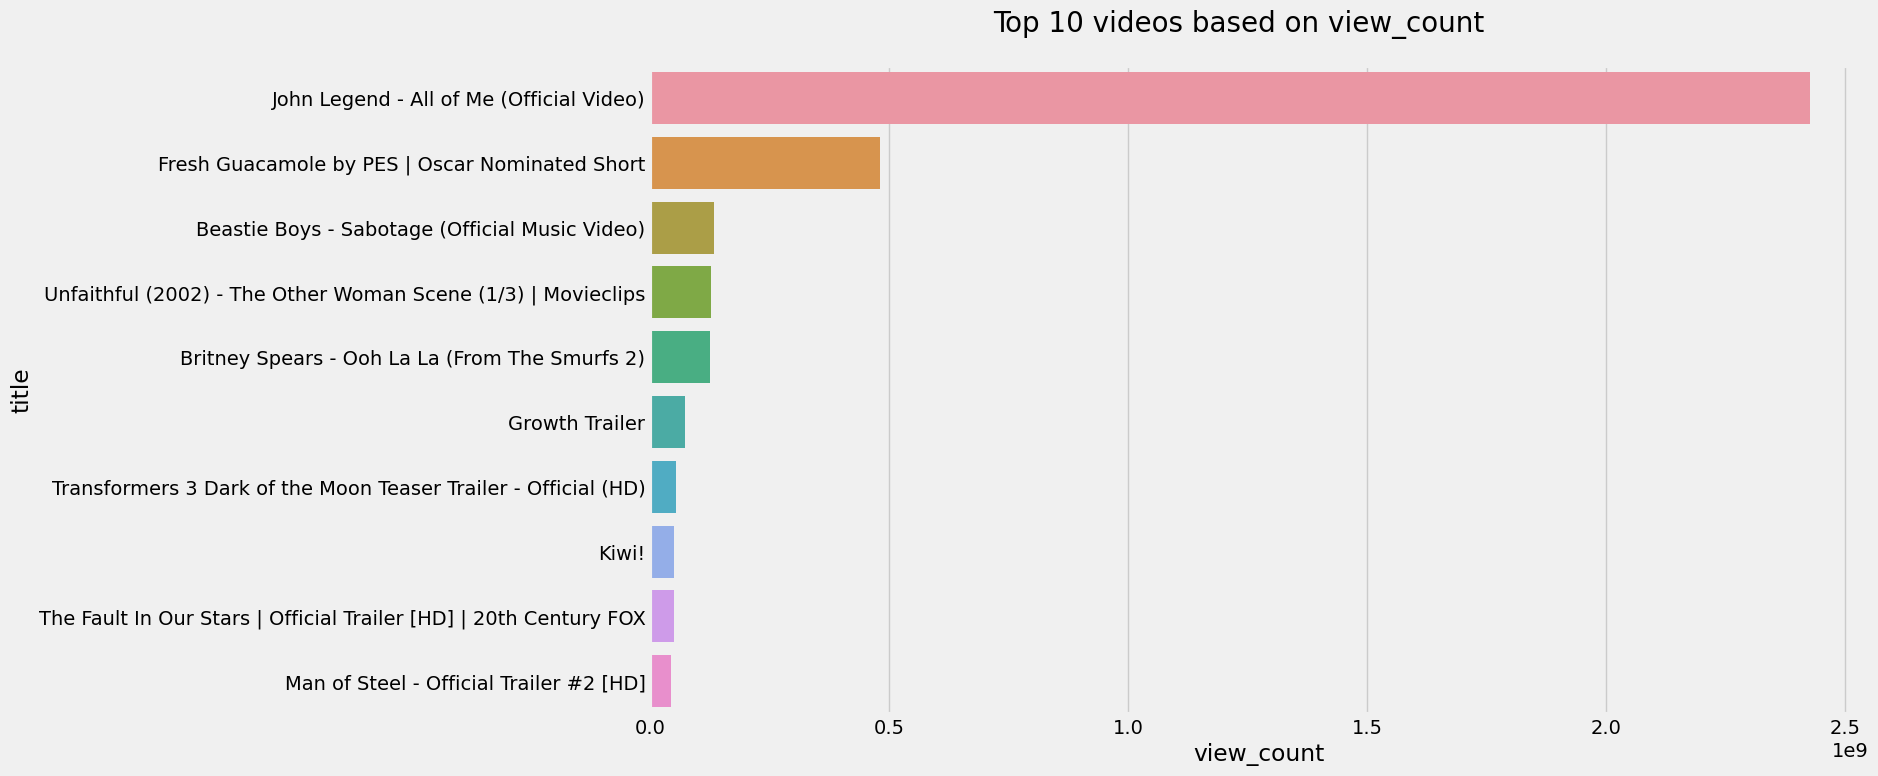

In [46]:
#df, feature, n_elements, how
youtube.sort_and_plot(df, 'view_count', 10, 'top')

## 2.	A list of the bottom-10 videos based on the total views 

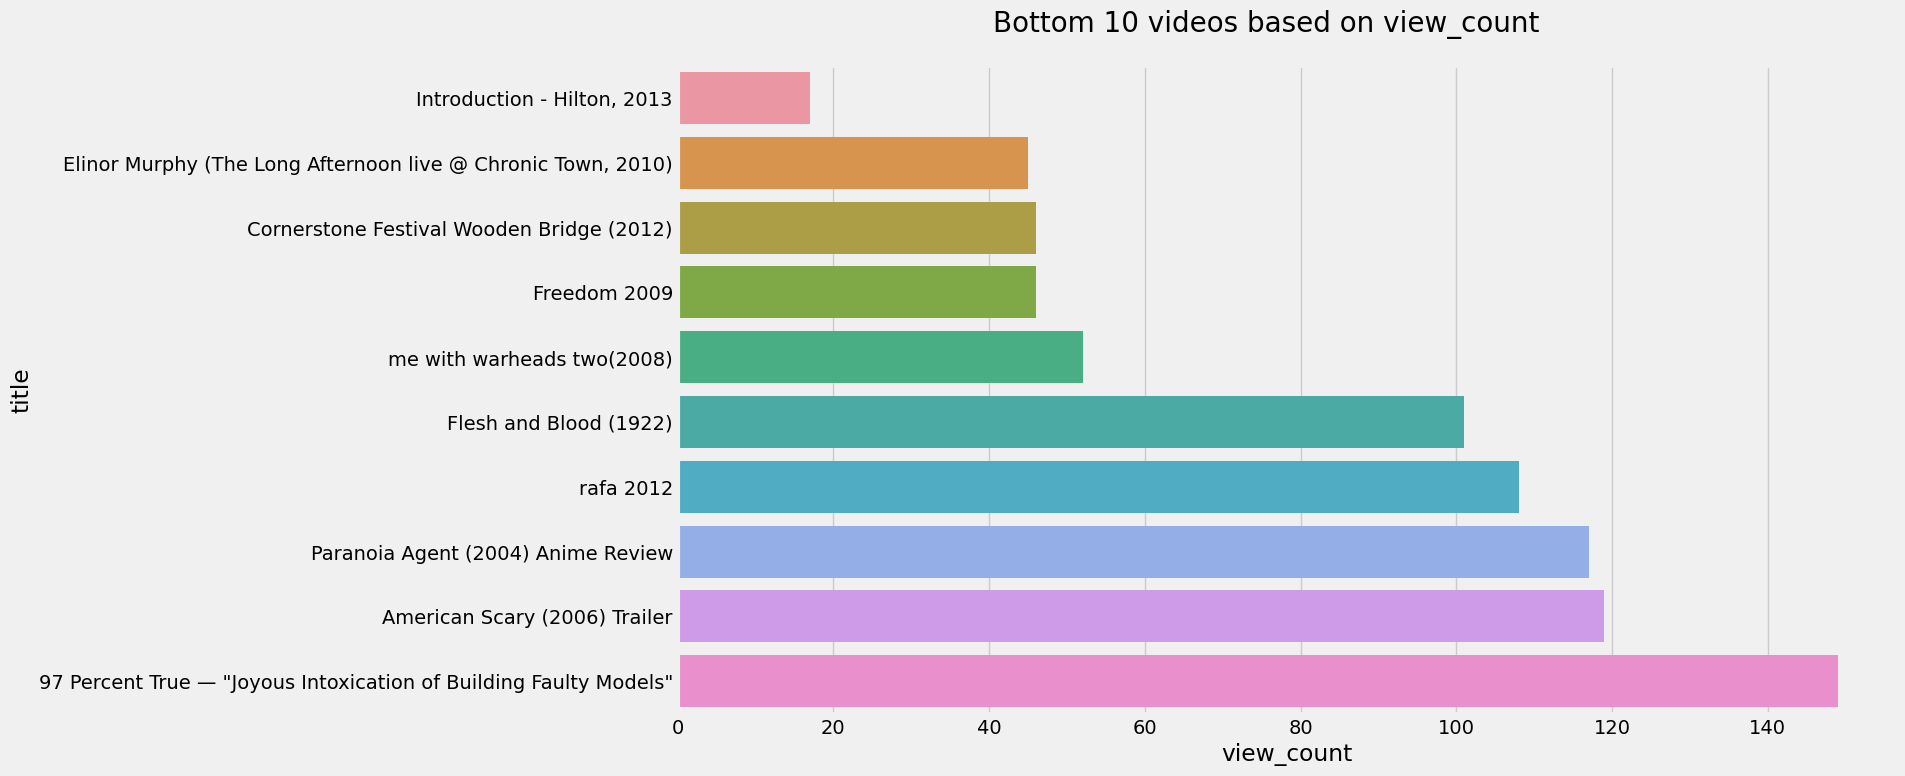

In [47]:
youtube.sort_and_plot(df, 'view_count', 10, 'bottom')

## 3.	The most liked video

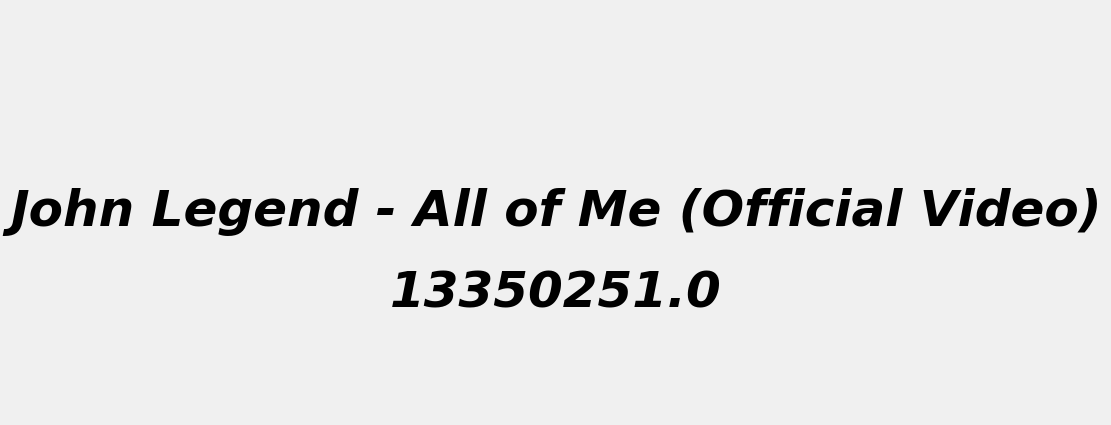

In [48]:
title = df.iloc[np.argmax(df['like_count'])]['title']
like_count = df.iloc[np.argmax(df['like_count'])]['like_count']
plt.figure(figsize=(10, 5))
plt.axis("off")  # turn off the axis
plt.text(0.5, 0.5, title, ha="center", va="center", fontsize=36, fontweight="bold", fontstyle="italic")  
plt.text(0.5, 0.3, str(like_count), ha="center", va="center", fontsize=36, fontweight="bold", fontstyle="italic")
plt.title("")  
plt.show()

## 4.	The least liked video 

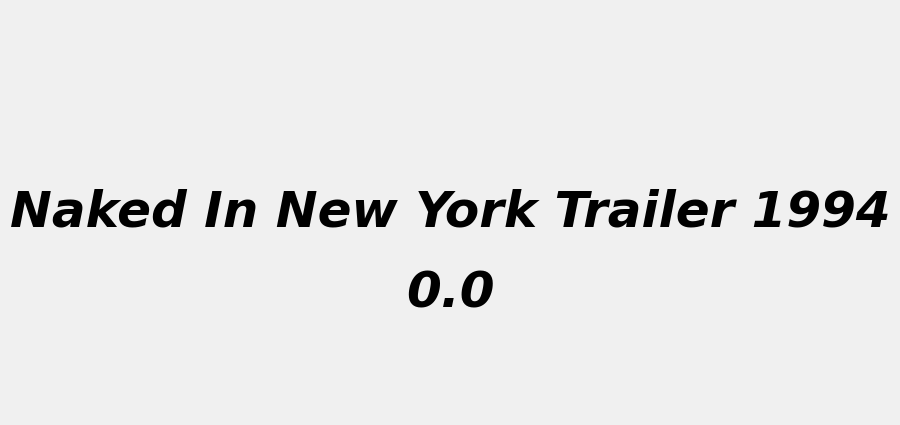

In [49]:
title = df.iloc[np.argmin(df['like_count'])]['title']
like_count = df.iloc[np.argmin(df['like_count'])]['like_count']
plt.figure(figsize=(10, 5))
plt.axis("off")  # turn off the axis
plt.text(0.5, 0.5, title, ha="center", va="center", fontsize=36, fontweight="bold", fontstyle="italic")  
plt.text(0.5, 0.3, str(like_count), ha="center", va="center", fontsize=36, fontweight="bold", fontstyle="italic")
plt.title("")  
plt.show()

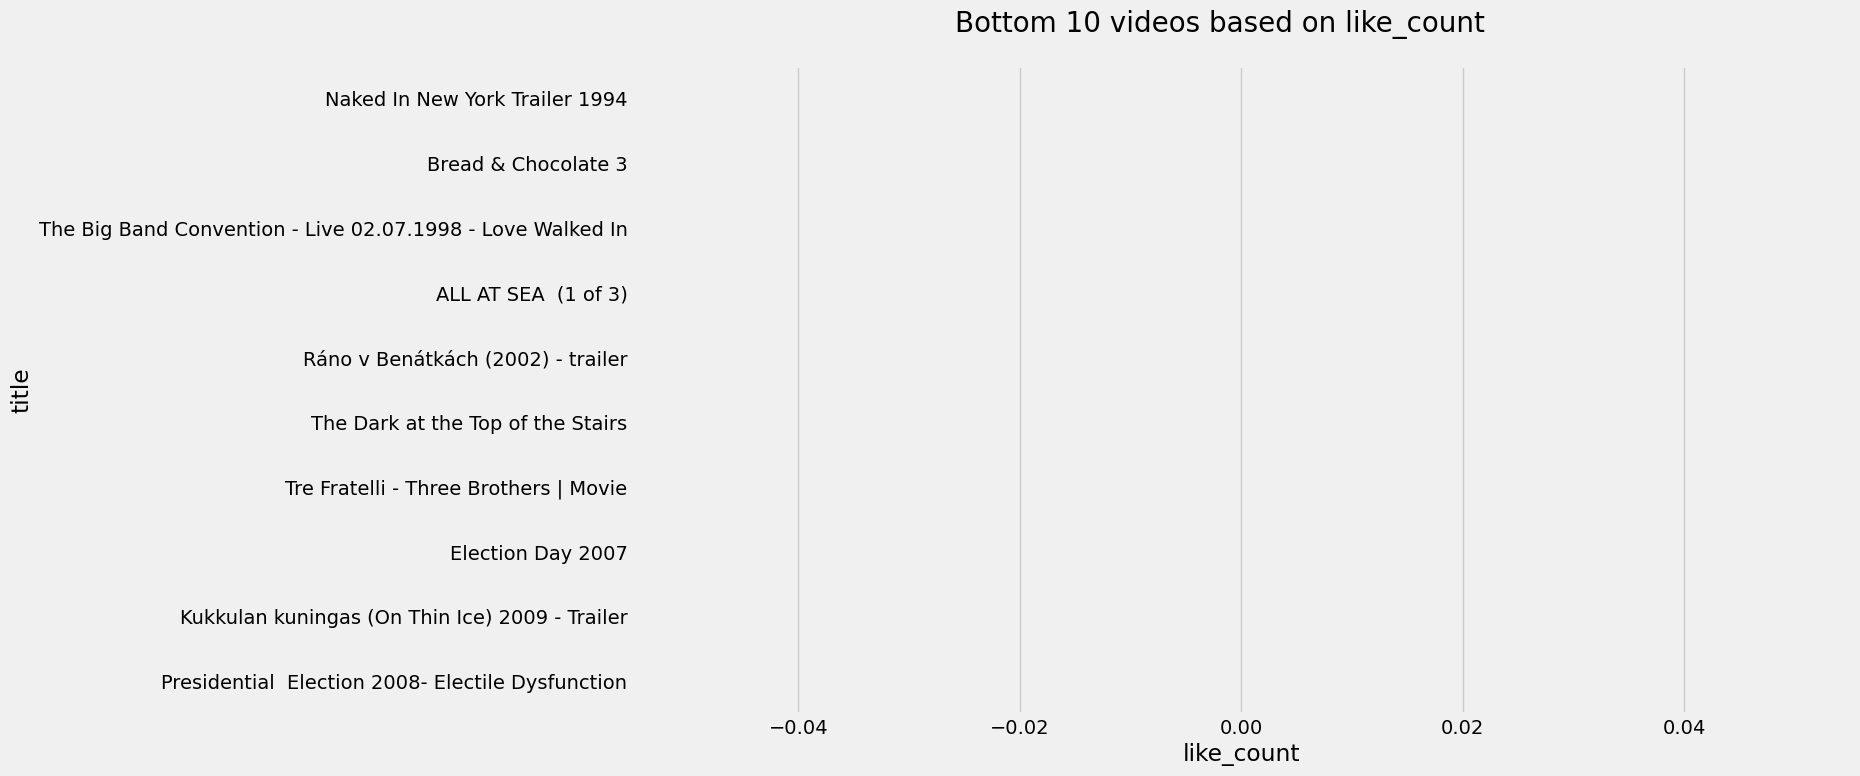

In [50]:
# verifyinh
youtube.sort_and_plot(df, 'like_count', 10, 'bottom')

## 5.	The video with the highest duration

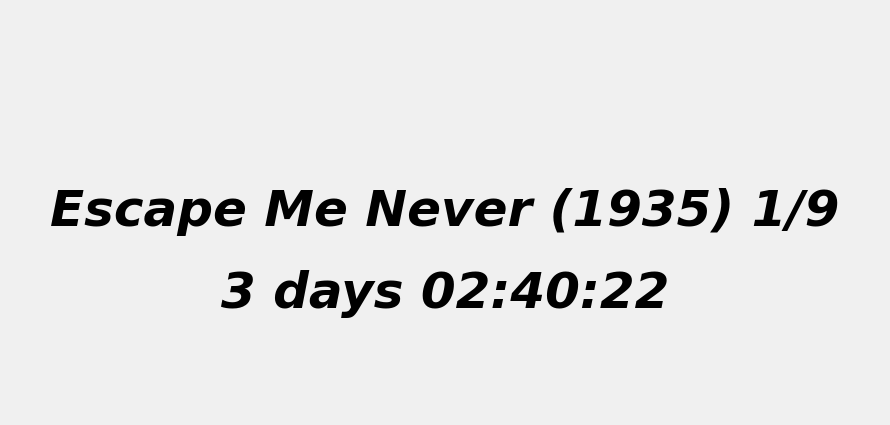

In [51]:
title = df.iloc[np.argmax(df['duration'])]['title']
like_count = df.iloc[np.argmax(df['duration'])]['duration']
plt.figure(figsize=(10, 5))
plt.axis("off")  # turn off the axis
plt.text(0.5, 0.5, title, ha="center", va="center", fontsize=36, fontweight="bold", fontstyle="italic")  
plt.text(0.5, 0.3, str(like_count), ha="center", va="center", fontsize=36, fontweight="bold", fontstyle="italic")
plt.title("")  
plt.show()

In [52]:
df[['title','duration']].sort_values(by='duration', ascending=False)[:10] # verifying

title        duration
24422                         Escape Me Never (1935) 1/9 3 days 02:40:22
17382                  Trailer for "Getting to Know You" 0 days 12:49:24
20538  The Century of the Self (Full Adam Curtis Docu... 0 days 03:54:44
24122                                Elvis and Me (1988) 0 days 03:04:07
24998            "THE TRIAL OF LEE HARVEY OSWALD" (1977) 0 days 03:03:23
16172                                          Otaku おたく 0 days 02:49:16
24051                                        ISHQ - 1997 0 days 02:48:23
21334    Destroy All Planets (aka Gamera vs. Viras) 1968 0 days 02:45:35
2077         Alfred Hitchcock: Blackmail and Easy Virtue 0 days 02:44:47
16989  Masti (2004) (HD) - Vivek Oberoi - Riteish Des... 0 days 02:31:56

# Sentiment Analysis 

In [53]:
text = df.comments.iloc[0]

print(text)

['Buena película de comedia romántica', '1:36 *GRUMPY⬅️ER* \n         *GRUMPIER*', "I'm watching this now, it never gets old🤣", 'Canaloni !!!!', "I was looking for halloween themed movies and stumbled over this... is there anything halloween related in this film?\n\n\nSeen it years ago but can't remember squat", 'welp, been 3 years since anybody have commented', 'Well, there was supposed to be another sequel. From what I heard, the two guys go to Italy (to meet their new relatives, I suppose) & wind up meeting Italian versions of themselves.', 'i loved the first one is it like the first one or not??']


In [54]:
def preprocess_comments(text):
    if type(text)!= str:
        return text
   # remove tags
    text = re.sub(r'<.*>', '', text)
    
    # remove astersik
    text = text.replace('*','')
    
    # replace preceeding and ending '[\]'
    text = re.sub(r'\[|]', '', text)

    # replace '\'
    text = re.sub(r'\\+', '', text)
    
    text = text.replace("'", '')
    text = text.replace('"', '')
    
    # remove extra whitespaces
    text = ' '.join(text.split())
    
    # remove escape characters
    text = text.replace('\\n', ' ')
    
    # remove tags
    text = html.unescape(text)
    
    # lower
    text = text.lower()
    
    # white spaces
    text = re.sub(r'\s+', ' ', text)
    
    return text 
    

In [55]:
# testing cleaning 
preprocess_comments(text)

'buena película de comedia romántica, 1:36 grumpy⬅️er n grumpier, im watching this now, it never gets old🤣, canaloni !!!!, i was looking for halloween themed movies and stumbled over this... is there anything halloween related in this film?nnnseen it years ago but cant remember squat, welp, been 3 years since anybody have commented, well, there was supposed to be another sequel. from what i heard, the two guys go to italy (to meet their new relatives, i suppose) & wind up meeting italian versions of themselves., i loved the first one is it like the first one or not??'

In [56]:
df['cleaned_comments'] = df['comments'].apply(preprocess_comments)

In [57]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Initialize VADER SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

def get_compound_score(comment):
    scores = analyzer.polarity_scores(comment)
    return scores['compound']

In [58]:
get_compound_score(df['cleaned_comments'].iloc[0])

0.932

In [59]:
df['compound_score'] = df['cleaned_comments'].apply(get_compound_score)

In [60]:
df.nlargest(10, 'compound_score')[['title','compound_score']]

title  compound_score
5                                Heat Trailer HD (1995)             1.0
911                     It's A Wonderful Life - Trailer             1.0
1227  Somewhere in Time Official Trailer #1 - Christ...             1.0
4119                       Trailer - 1978 - Ice Castles             1.0
5977                                  Born Free Trailer             1.0
5999      The Bible: In the Beginning... (1966) Trailer             1.0
6002         My Friend Flicka 01 of 39 - One Mans Horse             1.0
6917                  D.O.A. (1950) - Film Noir Classic             1.0
7125  Laws of Attraction (2004) Official Trailer - P...             1.0
7909  If a Man Answers, Hang up.  Presented by Preac...             1.0

In [61]:
df.nsmallest(10, 'compound_score')[['title','compound_score']]

title  compound_score
12325                   At The Death House Door: Trailer         -1.0000
13755            The Killing of John Lennon - UK trailer         -1.0000
16392                             The Tortured - Trailer         -1.0000
17272  Into the Abyss (Death Row Documentary) [2011] ...         -1.0000
18587                            Waco - A New Revelation         -1.0000
18823               The Invisible War - Official Trailer         -1.0000
19996  Dirty Wars - Official Trailer (HD) Documentary...         -1.0000
3337                         Rules Of Engagement Trailer         -0.9999
5460           Grave of the Fireflies - Official Trailer         -0.9999
10598                                 Hard Candy Trailer         -0.9999

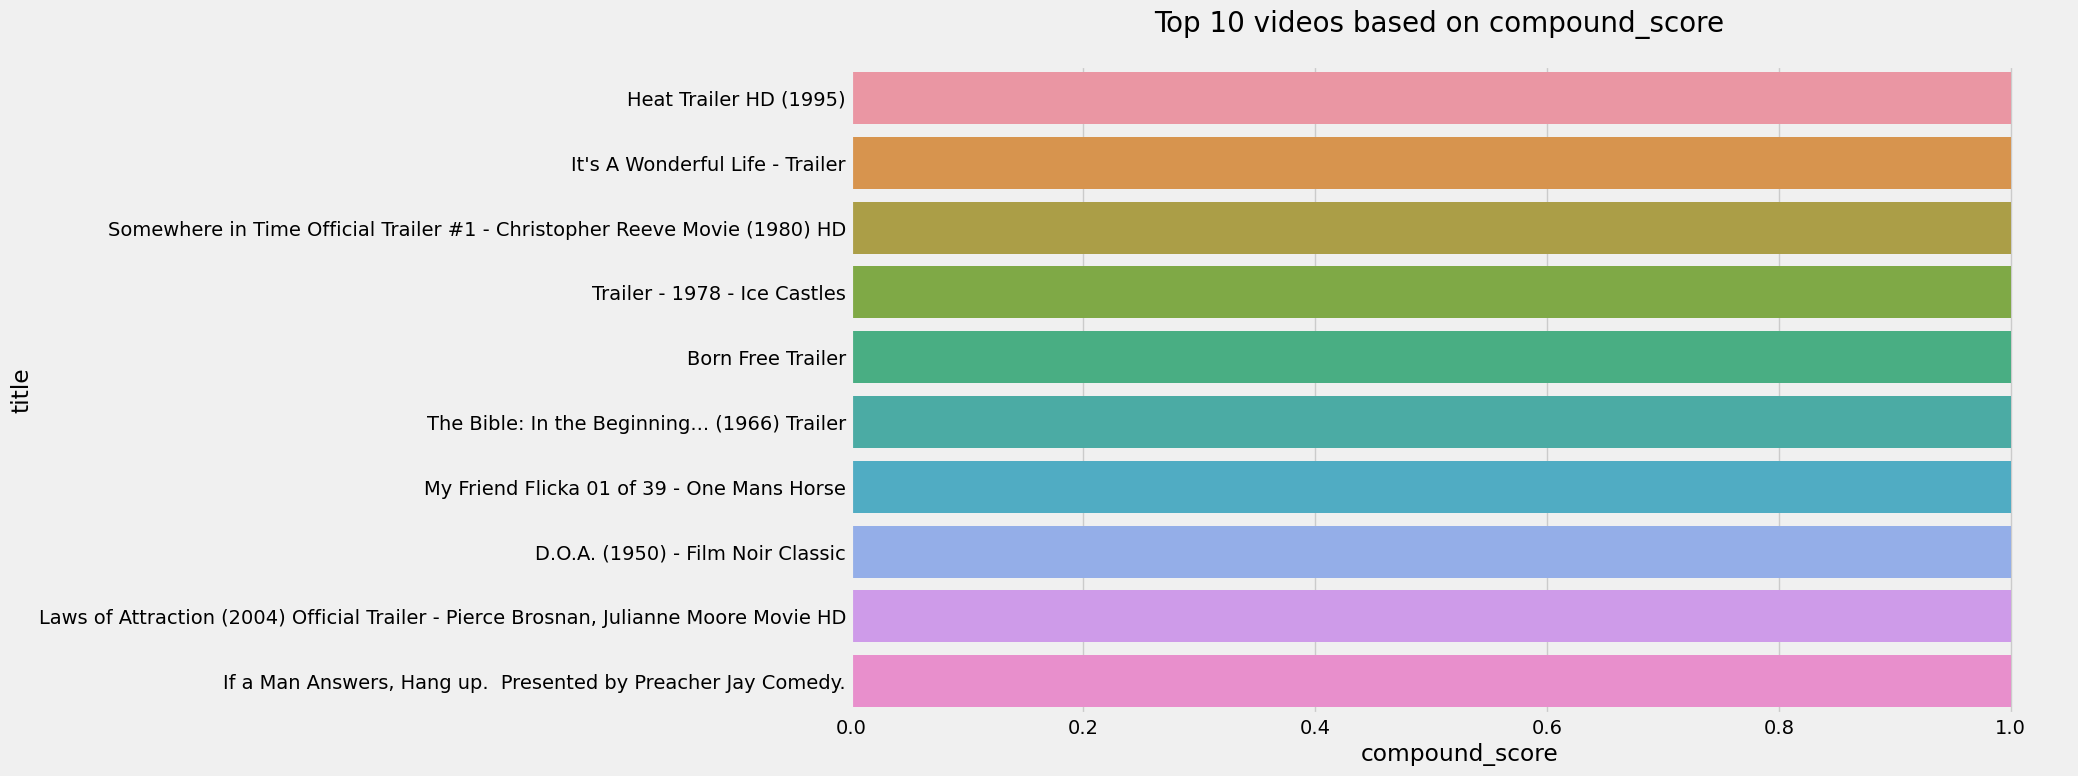

In [62]:
youtube.sort_and_plot(df, 'compound_score', 10, 'top')

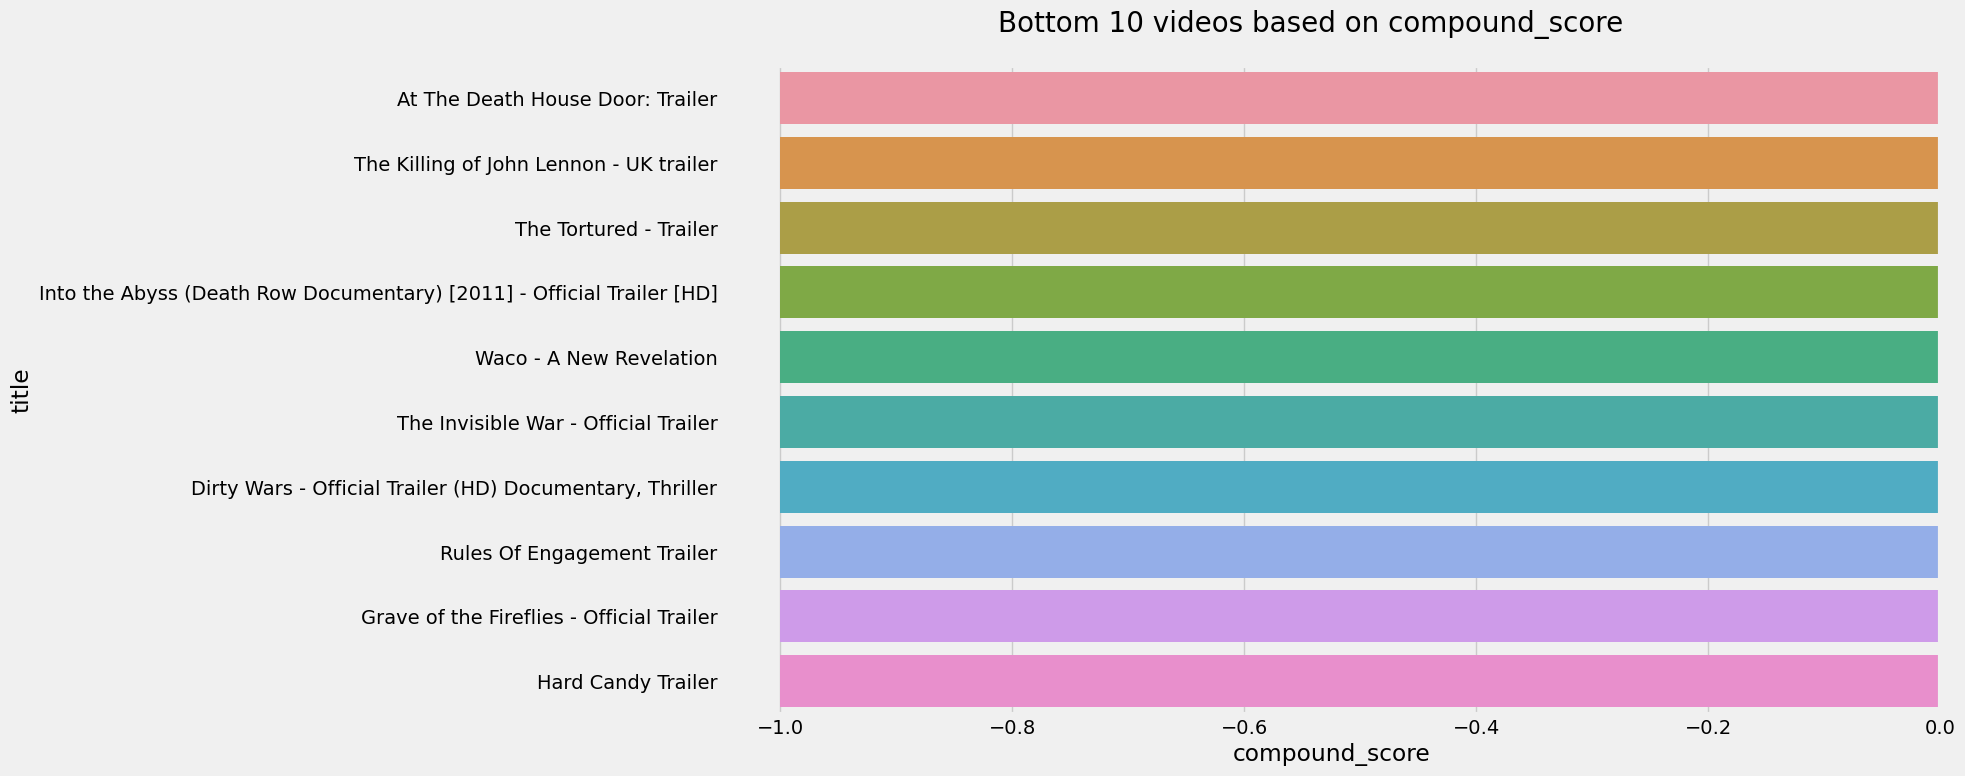

In [63]:
youtube.sort_and_plot(df, 'compound_score', 10, 'bottom')

# Part -2  (GOOGLE NEWS DATA)

## DO NOT EXECUTE THESE STEPS...SCRAPING HAS ALREADY BEEN DONE

In [64]:
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns
# from bs4 import BeautifulSoup

# import re

# # get headlines
# def get_headlines(topic,lang,country):
#     headlines_details = []
#     gn = GoogleNews(lang=lang,country=country)
#     headlines = gn.topic_headlines(topic)
#     newsitems = headlines['entries']
#     for item in newsitems:
#         story = {
#             'title' : item.title,
#             #'topic':topic,
#             'Published_on' : item.published,
#             'News_agency' : item.source['title'],
#             'URL' : item.link,
#             'summary':item.summary,
#             'Country': country,
#             'language': lang,
#             'tag': topic
#         }
#         headlines_details.append(story)
#     return headlines_details


# possible_countries = ["US", "GB", "CA", "AU", "DE", "FR", "ES", "IT", "JP", "CN", "RU", "BR", "IN"]
# languages = ['en']
# headlines_topics= ['WORLD','NATION','BUSINESS','TECHNOLOGY','ENTERTAINMENT','SCIENCE','SPORTS','HEALTH']


# x = []
# # the main df
# for loc in possible_countries:
#     for lang in languages:
#         for topic in headlines_topics:
#             print("printing topic",topic)
#             print('printing lang',lang)
#             print('printing country',loc)
#             x.append(get_headlines(topic,lang,loc))

            
# main_list=[]
# for list_of_dicts in x:
#     for d in list_of_dicts:
#         main_list.append(d)            
        
# df = pd.DataFrame(main_list)
# df.head()
# df.to_csv('Google_news_data',index= False)

## DATASET EXPLORATION

In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup
import re
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import stopwords
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import string
stopwords_eng = stopwords.words("english")

import nltk

plt.style.use('fivethirtyeight')
import warnings                    
warnings.filterwarnings('ignore')  

In [66]:
# global class for googlenews processing
class GoogleNews():
    """
    Description: This is a global class which contains functions for most of the activities performed in this script.
    """
    def __init__(self):
        pass
    
    def report(self, df):
        """
        Description:
        ---------------
        Function to display summary of the dataset.
        
        Arguments:
        ---------------
        df (pd.DataFrame) : Take a Dataframe object as input
        
        Returns:
        ---------------
        Returns a detailed report on meta data of the dataset, details like null values, duplicates, column types, statistatical summary etc 
        are displayed.
        """
        self.df = df
        print('******INFORMATION OF THE DATASET:******\n')
        print(f'Shape of the dataset: {df.shape},\n\nNumber of rows: {df.shape[0]},\nNumber of Columns: {df.shape[1]}')
        print('=' * 70)
        print('*** Information per column ***\n')
        print(df.info())
        print('=' * 70)
        
        print('*** COLUMNS IN THE DATAFRAME***\n')
        print(df.columns)
        print('=' * 70)
        
        # Null values
        print('*** COUNT OF NULL VALUES PER COLUMN ***\n')
        print(df.isnull().sum())
        print('=' * 70)
        print('Normalized:\n')
        print(df.isnull().mean()*100)
        print('=' * 70)
        
        # Duplicate entries
        print('*** COUNT OF DUPLICATE ENTRIES ***\n')
        print(f'The dataset has a total of {df.duplicated().sum()} duplicate entries')
        print('=' * 70)
        
        # Numerical and categorical columns
        print('*** COLUMN TYPES IN THE DATAFRAME ***\n')
        print('NUMERICAL COLUMNS: {}'.format([i for i in df.columns if df[i].dtype!='O']))
        print('\n')
        print('CATEGORICAL COLUMNS: {}'.format([i for i in df.columns if df[i].dtype=='O']))
        print('=' * 70)
        
        # Unique values per column
        print('*** COUNT OF UNIQUE VALUES PER COLUMN ***\n')
        [print(f'{x} :', df[x].nunique()) for x in df.columns if x!= 'URL' and x!= 'summary' and x!= 'Published_on' and x!= 'title']
        print('=' * 70)
        print('*** UNIQUE VALUES PER COLUMN ***\n')
        [print(f'{x} :\n', df[x].unique()) for x in df.columns if x!= 'URL' and x!= 'summary' and x!= 'Published_on' and x!= 'title']
        print('=' * 70)
        
        # Statistical summary
        print('*** STATISTICAL SUMMARY ***\n')
        print(df.describe().T)
        print('=' * 70)
        
    ####################################################################################################    
    ## VISUAL REPORT
    def visua_report(self, df):
        """
        Description:
        ---------------
        Function to display visual summary of the dataset.
        
        Arguments:
        ---------------
        df (pd.DataFrame) : Take a Dataframe object as input
        
        Returns:
        ---------------
        Returns a detailed report on meta data of the dataset, details like null values, duplicates, column types, statistatical summary etc 
        are displayed.
        
        NOTE: ONLY TO BE USED ON PREPROCESSED DATASET
        """
        self.df = df
       
        # year publihed..
        plt.figure(figsize=(14, 8))
        bars = sns.countplot(x = df['published_year'])
        plt.xlabel('Year')
        plt.ylabel('Frequency')
        plt.title('News Per Year', fontsize=20)
        for bar in bars.patches:
            plt.annotate(str(bar.get_height()), xy=(bar.get_x() + bar.get_width() / 2, bar.get_height()), 
                         xytext=(0, 1.25), 
                         textcoords="offset points",
                         ha='center', va='bottom')
        plt.show()
        
        # month publihed..
        plt.figure(figsize=(14, 8))
        bars = sns.countplot(x = df['published_month'])
        plt.xlabel('Month')
        plt.ylabel('Frequency')
        plt.title('News Per Month', fontsize=20)
        for bar in bars.patches:
            plt.annotate(str(bar.get_height()), xy=(bar.get_x() + bar.get_width() / 2, bar.get_height()), 
                         xytext=(0, 1.25), 
                         textcoords="offset points",
                         ha='center', va='bottom')
        plt.show()
        
        # distribution of country....
        plt.figure(figsize=(14, 8))
        bars = sns.countplot(x = df['Country'])
        plt.xlabel('Country')
        plt.ylabel('Frequency')
        plt.title('Count of countries',  fontsize=20)
        for bar in bars.patches:
            plt.annotate(str(bar.get_height()), xy=(bar.get_x() + bar.get_width() / 2, bar.get_height()), 
                         xytext=(0, 1.25), 
                         textcoords="offset points",
                         ha='center', va='bottom')
        plt.show()
        
         # distribution of tag..
        plt.figure(figsize=(14, 8))
        bars = sns.countplot(x = df['tag'])
        plt.xlabel('Topics')
        plt.ylabel('Frequency')
        plt.xticks(rotation=45)
        plt.title('Topics Distribution', fontsize=20)

        for bar in bars.patches:
            plt.annotate(str(bar.get_height()), xy=(bar.get_x() + bar.get_width() / 2, bar.get_height()), 
                         xytext=(0, 1.25), 
                         textcoords="offset points",
                         ha='center', va='bottom')
    
        plt.show()
        
        # Top 10 news agencies (count)..
        x = df.News_agency.value_counts().sort_values(ascending=False)[:10]
        plt.figure(figsize=(14, 8))
        sns.barplot(x = x.index, y= x.values)

        for bar in plt.gca().patches:
            plt.annotate(str(bar.get_height()), xy=(bar.get_x() + bar.get_width() / 2, bar.get_height()), 
                     xytext=(0, 1.25), 
                     textcoords="offset points",
                     ha='center', va='bottom')

        plt.xlabel('News Agencies')
        plt.ylabel('Count')
        plt.xticks(rotation=45)
        plt.title('Top 10 News agencies (count)', fontsize=20)
        plt.show()
        
        # distribution of word count..
        plt.figure(figsize=(20, 5))
        bars = sns.countplot(x = df['word_count'])
        plt.title('Count of words per description', fontdict={'fontsize': 20})
        plt.xlabel('Count')
        plt.ylabel('freq')
        plt.xticks(rotation =90, fontsize =10)

        # annotating only the highest bar..
        plt.annotate(str(bars.patches[0].get_height()), xy=(bars.patches[0].get_x() + bars.patches[0].get_width() / 2, bars.patches[0].get_height()),
                     xytext=(0, 1.25), 
                     textcoords="offset points",
                     ha='center', va='bottom')

        plt.show()
      
    ####################################################################################################
    # Helper functions should be defined at the class level
    def lower(self, text):
        return text.lower()
    
    def remove_whitespaces(self, text):
        return text.strip()
    
    def remove_punctuations(self, text):
        return text.translate(str.maketrans('', '', string.punctuation))
    
    def tokenize(self, text): 
        return word_tokenize(text)
    
    def remove_stopwords(self, tokens):
        return [word for word in tokens if word not in set(stopwords.words('english')) and len(word) > 3]
    
    def lemmatize(self, tokens):
        lemmatizer = WordNetLemmatizer()
        return [lemmatizer.lemmatize(token) for token in tokens]
    
    def stem_words(self, lemmas):
        stemmer = PorterStemmer()
        return [stemmer.stem(lemma) for lemma in lemmas]
    
    # The preprocess function should also be defined at the class level
    def preprocess(self, text):
        """
        Description:
        ---------------
        Function to preprocess text.
        
        Arguments:
        ---------------
        text (str) : text to preprocess
        
        Returns:
        ---------------
        tokens (list) : returns a list of tokens that are preprocessed using various helper functions.
        """
        lowered_text = self.lower(text)
        strip_text = self.remove_whitespaces(lowered_text)
        no_punc_text = self.remove_punctuations(strip_text)
        tokens = self.tokenize(no_punc_text)
        no_stop_words = self.remove_stopwords(tokens)
        lemma_words = self.lemmatize(no_stop_words)
        cleaned_text = self.stem_words(lemma_words)
        return cleaned_text
    ####################################################################################################
    # functions to create word clouds...
    
    def create_wordclouds(self, df):
        """
        Description:
        ---------------
        Function to create wordclouds.
        
        Arguments:
        ---------------
        df (pd.DataFrame) : Take a Dataframe object as input
        
        Returns:
        ---------------
        Displays wordclouds.
        
        NOTE: ONLY USED ON MERGED_TS AND PREPROCESSED_TEXT
        """
        # word cloud 1..(merged_TS)
        text = ' '.join(df['merged_TS'])

        plt.figure(figsize = (20,20))
        plt.suptitle('MERGED TITLE AND SUMMARY', y=0.95, fontsize = 24)

        wordcloud = WordCloud(max_words = 200 , width = 1000 , height = 1000 , background_color="white",include_numbers=False).generate(text)

        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis("off")
        plt.show()
        
        #word cloud 2..(Preprocessed text)
        text = ' '.join(df['preprocessed_text'])

        plt.figure(figsize = (20,20))
        plt.suptitle('PREPROCESSED TEXT', y=0.95, fontsize = 24)

        wordcloud = WordCloud(max_words = 200 , width = 1000 , height = 1000 , background_color="white",include_numbers=False).generate(text)

        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis("off")
        plt.show()

In [67]:
# NOTE: Change the import path accordingly..
df = pd.read_csv('C:\\Users\\rohan aryan\\Desktop\\lambton\\Temp_REPOS\\GoogleNewsData-Social_Media_Analytics\\Dataset\\Google_news_data.csv')

In [68]:
df.head()

title  \
0  Canada and India expel diplomats over killing ...   
1  U.S. raises concern with Israel as Gaza hospit...   
2  Artificial Intelligence Raises Ukrainian Drone...   
3  Lebanon’s emergency workers pay a deadly price...   
4  Tourist dies trying to climb Spanish bridge fo...   

                    Published_on          News_agency  \
0  Tue, 15 Oct 2024 13:14:51 GMT      Financial Times   
1  Tue, 15 Oct 2024 13:51:42 GMT             CBS News   
2  Mon, 14 Oct 2024 11:38:05 GMT            Kyiv Post   
3  Tue, 15 Oct 2024 12:14:56 GMT              BBC.com   
4  Tue, 15 Oct 2024 11:45:04 GMT  The Washington Post   

                                                 URL  \
0  https://news.google.com/rss/articles/CBMicEFVX...   
1  https://news.google.com/rss/articles/CBMiowFBV...   
2  https://news.google.com/rss/articles/CBMiS0FVX...   
3  https://news.google.com/rss/articles/CBMiWkFVX...   
4  https://news.google.com/rss/articles/CBMiiwFBV...   

                                             summary Country language    tag  
0  <ol><li><a href="https://news.google.com/rss/a...      US       en  WORLD  
1  <ol><li><a href="https://news.google.com/rss/a...      US       en  WORLD  
2  <ol><li><a href="https://news.google.com/rss/a...      US       en  WORLD  
3  <ol><li><a href="https://news.google.com/rss/a...      US       en  WORLD  
4  <ol><li><a href="https://news.google.com/rss/a...      US       en  WORLD

In [69]:
google = GoogleNews()
google.report(df)

******INFORMATION OF THE DATASET:******

Shape of the dataset: (6128, 8),

Number of rows: 6128,
Number of Columns: 8
*** Information per column ***

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6128 entries, 0 to 6127
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   title         6128 non-null   object
 1   Published_on  6128 non-null   object
 2   News_agency   6128 non-null   object
 3   URL           6128 non-null   object
 4   summary       6128 non-null   object
 5   Country       6128 non-null   object
 6   language      6128 non-null   object
 7   tag           6128 non-null   object
dtypes: object(8)
memory usage: 383.1+ KB
None
*** COLUMNS IN THE DATAFRAME***

Index(['title', 'Published_on', 'News_agency', 'URL', 'summary', 'Country',
       'language', 'tag'],
      dtype='object')
*** COUNT OF NULL VALUES PER COLUMN ***

title           0
Published_on    0
News_agency     0
URL             0
summar

In [70]:
# Preprocessing of columns, Validations
# converting it to right format
df['published_date'] = pd.to_datetime(df['Published_on'])
# extracting yr, dt, mn
df['published_year'] = df['published_date'].dt.year
df['published_month'] = df['published_date'].dt.month
df['published_day'] = df['published_date'].dt.day

In [71]:
# preprocessing summary
def parse_html(content):
    soup = BeautifulSoup(content, 'html.parser')
    summ = []
    for item in soup.find_all('li'):
        text = item.find('a').text
        summ.append(text)
    return ' '.join(summ)

# checking the function
content = df.summary.iloc[0]
text = parse_html(content)
print(text)

Canada and India expel diplomats over killing of Sikh activist Trudeau’s Move Casts Light on the Reach of India’s Intelligence Agencies Canada-India diplomatic row over Sikh activist's assassination grows as top diplomats are expelled Canadian police accuse India of working with criminal network to kill dissidents


In [72]:
# committing changes
df['summary'] = df['summary'].apply(parse_html)
# checking a random value
df['summary'].values[121]

'Stock futures are little changed after Dow closes above 43,000 for the first time: Live updates Stock market today: Nasdaq jumps, S&P 500 trades at record high with earnings on deck U.S. stocks add to all-time high with more gains on Monday Dow Jones Futures: S&P 500 Hits New High As Nvidia Closes At Record Level Forbes Daily: S&P 500 Hits New High On Strong Bank Earnings'

In [73]:
def clean_news_agency(text):
    for agencies in df['News_agency']:
        pattern = r'([.]com|[.]au|[.]org|[.]gov)'
        news_agency = re.sub(pattern, '', text)
    return news_agency

# testing the function
text = 'CNN.com'
cleaned_text = clean_news_agency(text)
print(cleaned_text) # works

CNN


In [74]:
df['News_agency'] = df['News_agency'].apply(clean_news_agency)
df.query('News_agency == "CNN"')[:5]

title  \
9   US suggests military aid to Israel is at risk ...   
19  Deadly drone attack by Hezbollah exposes Israe...   
43  The Sahara Desert flooded for the first time i...   
46  One’s got a big appetite, the other’s a bit of...   
57  In Colin Allred, Ted Cruz once again facing a ...   

                     Published_on News_agency  \
9   Tue, 15 Oct 2024 15:32:00 GMT         CNN   
19  Mon, 14 Oct 2024 19:38:00 GMT         CNN   
43  Mon, 14 Oct 2024 19:14:00 GMT         CNN   
46  Tue, 15 Oct 2024 14:57:00 GMT         CNN   
57  Tue, 15 Oct 2024 08:00:00 GMT         CNN   

                                                  URL  \
9   https://news.google.com/rss/articles/CBMimwFBV...   
19  https://news.google.com/rss/articles/CBMipgFBV...   
43  https://news.google.com/rss/articles/CBMihAFBV...   
46  https://news.google.com/rss/articles/CBMilAFBV...   
57  https://news.google.com/rss/articles/CBMigwFBV...   

                                              summary Country language  \
9   US suggests military aid to Israel is at risk ...      US       en   
19  Deadly drone attack by Hezbollah exposes Israe...      US       en   
43  The Sahara Desert flooded for the first time i...      US       en   
46  One’s got a big appetite, the other’s a bit of...      US       en   
57  In Colin Allred, Ted Cruz once again facing a ...      US       en   

       tag      published_date  published_year  published_month  published_day  
9    WORLD 2024-10-15 15:32:00            2024               10             15  
19   WORLD 2024-10-14 19:38:00            2024               10             14  
43   WORLD 2024-10-14 19:14:00            2024               10             14  
46  NATION 2024-10-15 14:57:00            2024               10             15  
57  NATION 2024-10-15 08:00:00            2024               10             15

In [75]:
# overview of df so far..
df.head()

title  \
0  Canada and India expel diplomats over killing ...   
1  U.S. raises concern with Israel as Gaza hospit...   
2  Artificial Intelligence Raises Ukrainian Drone...   
3  Lebanon’s emergency workers pay a deadly price...   
4  Tourist dies trying to climb Spanish bridge fo...   

                    Published_on          News_agency  \
0  Tue, 15 Oct 2024 13:14:51 GMT      Financial Times   
1  Tue, 15 Oct 2024 13:51:42 GMT             CBS News   
2  Mon, 14 Oct 2024 11:38:05 GMT            Kyiv Post   
3  Tue, 15 Oct 2024 12:14:56 GMT                  BBC   
4  Tue, 15 Oct 2024 11:45:04 GMT  The Washington Post   

                                                 URL  \
0  https://news.google.com/rss/articles/CBMicEFVX...   
1  https://news.google.com/rss/articles/CBMiowFBV...   
2  https://news.google.com/rss/articles/CBMiS0FVX...   
3  https://news.google.com/rss/articles/CBMiWkFVX...   
4  https://news.google.com/rss/articles/CBMiiwFBV...   

                                             summary Country language    tag  \
0  Canada and India expel diplomats over killing ...      US       en  WORLD   
1  U.S. raises concern with Israel as Gaza hospit...      US       en  WORLD   
2  Artificial Intelligence Raises Ukrainian Drone...      US       en  WORLD   
3  Lebanon’s emergency workers pay a deadly price...      US       en  WORLD   
4  Tourist dies trying to climb Spanish bridge fo...      US       en  WORLD   

       published_date  published_year  published_month  published_day  
0 2024-10-15 13:14:51            2024               10             15  
1 2024-10-15 13:51:42            2024               10             15  
2 2024-10-14 11:38:05            2024               10             14  
3 2024-10-15 12:14:56            2024               10             15  
4 2024-10-15 11:45:04            2024               10             15

In [76]:
# feature engineering..
# lets create word count, sentence count, stopwords_count columns to understand the count of words per summary for each article
def counts(text):
    word_count = len(word_tokenize(text))
    sentence_count = len(sent_tokenize(text))
    stop_count = sum(1 for i in word_tokenize(text) if i.lower() in set(stopwords.words('english')))
    return word_count, sentence_count, stop_count

# testing the function
text = df.summary.values[0]
word_count, sentence_count, stop_count = counts(text)
print(f'word count: {word_count}\nsentence count: {sentence_count}\nstopwords: {stop_count}')

word count: 51
sentence count: 1
stopwords: 14


In [77]:
# this function will consider special characters as well as they are a part of the summary (raw form)
df['word_count'], df['sent_count'], df['stopwords_count'] = zip(*df['summary'].apply(counts))

In [78]:
df.head()

title  \
0  Canada and India expel diplomats over killing ...   
1  U.S. raises concern with Israel as Gaza hospit...   
2  Artificial Intelligence Raises Ukrainian Drone...   
3  Lebanon’s emergency workers pay a deadly price...   
4  Tourist dies trying to climb Spanish bridge fo...   

                    Published_on          News_agency  \
0  Tue, 15 Oct 2024 13:14:51 GMT      Financial Times   
1  Tue, 15 Oct 2024 13:51:42 GMT             CBS News   
2  Mon, 14 Oct 2024 11:38:05 GMT            Kyiv Post   
3  Tue, 15 Oct 2024 12:14:56 GMT                  BBC   
4  Tue, 15 Oct 2024 11:45:04 GMT  The Washington Post   

                                                 URL  \
0  https://news.google.com/rss/articles/CBMicEFVX...   
1  https://news.google.com/rss/articles/CBMiowFBV...   
2  https://news.google.com/rss/articles/CBMiS0FVX...   
3  https://news.google.com/rss/articles/CBMiWkFVX...   
4  https://news.google.com/rss/articles/CBMiiwFBV...   

                                             summary Country language    tag  \
0  Canada and India expel diplomats over killing ...      US       en  WORLD   
1  U.S. raises concern with Israel as Gaza hospit...      US       en  WORLD   
2  Artificial Intelligence Raises Ukrainian Drone...      US       en  WORLD   
3  Lebanon’s emergency workers pay a deadly price...      US       en  WORLD   
4  Tourist dies trying to climb Spanish bridge fo...      US       en  WORLD   

       published_date  published_year  published_month  published_day  \
0 2024-10-15 13:14:51            2024               10             15   
1 2024-10-15 13:51:42            2024               10             15   
2 2024-10-14 11:38:05            2024               10             14   
3 2024-10-15 12:14:56            2024               10             15   
4 2024-10-15 11:45:04            2024               10             15   

   word_count  sent_count  stopwords_count  
0          51           1               14  
1          55           1                9  
2          42           1                8  
3          71           1               18  
4          74           1               19

In [79]:
# we dont require published_on
df.drop(columns='Published_on', inplace=True)

In [80]:
df.head()

title          News_agency  \
0  Canada and India expel diplomats over killing ...      Financial Times   
1  U.S. raises concern with Israel as Gaza hospit...             CBS News   
2  Artificial Intelligence Raises Ukrainian Drone...            Kyiv Post   
3  Lebanon’s emergency workers pay a deadly price...                  BBC   
4  Tourist dies trying to climb Spanish bridge fo...  The Washington Post   

                                                 URL  \
0  https://news.google.com/rss/articles/CBMicEFVX...   
1  https://news.google.com/rss/articles/CBMiowFBV...   
2  https://news.google.com/rss/articles/CBMiS0FVX...   
3  https://news.google.com/rss/articles/CBMiWkFVX...   
4  https://news.google.com/rss/articles/CBMiiwFBV...   

                                             summary Country language    tag  \
0  Canada and India expel diplomats over killing ...      US       en  WORLD   
1  U.S. raises concern with Israel as Gaza hospit...      US       en  WORLD   
2  Artificial Intelligence Raises Ukrainian Drone...      US       en  WORLD   
3  Lebanon’s emergency workers pay a deadly price...      US       en  WORLD   
4  Tourist dies trying to climb Spanish bridge fo...      US       en  WORLD   

       published_date  published_year  published_month  published_day  \
0 2024-10-15 13:14:51            2024               10             15   
1 2024-10-15 13:51:42            2024               10             15   
2 2024-10-14 11:38:05            2024               10             14   
3 2024-10-15 12:14:56            2024               10             15   
4 2024-10-15 11:45:04            2024               10             15   

   word_count  sent_count  stopwords_count  
0          51           1               14  
1          55           1                9  
2          42           1                8  
3          71           1               18  
4          74           1               19

## Preprocessing pipeline

In [81]:
# testing the preprocessing pipeline
text = df.summary.iloc[0]
cleaned_text = google.preprocess(text)
print(cleaned_text)

['canada', 'india', 'expel', 'diplomat', 'kill', 'sikh', 'activist', 'trudeau', 'move', 'cast', 'light', 'reach', 'india', 'intellig', 'agenc', 'canadaindia', 'diplomat', 'sikh', 'activist', 'assassin', 'grow', 'diplomat', 'expel', 'canadian', 'polic', 'accus', 'india', 'work', 'crimin', 'network', 'kill', 'dissid']


In [82]:
# lets make a column with title + summary to reserve as much information as possible..
df['merged_TS'] = df['title'] + ' ' + df['summary']

In [83]:
# checking..
df.merged_TS.iloc[0]

"Canada and India expel diplomats over killing of Sikh activist - Financial Times Canada and India expel diplomats over killing of Sikh activist Trudeau’s Move Casts Light on the Reach of India’s Intelligence Agencies Canada-India diplomatic row over Sikh activist's assassination grows as top diplomats are expelled Canadian police accuse India of working with criminal network to kill dissidents"

In [84]:
# lets run the preprocessing pipeline on the merged feature
df['preprocessed_text'] = df['merged_TS'].apply(google.preprocess)

In [85]:
df['preprocessed_text'].head()

0    [canada, india, expel, diplomat, kill, sikh, a...
1    [rais, concern, israel, gaza, hospit, strike, ...
2    [artifici, intellig, rais, ukrainian, drone, k...
3    [lebanon, emerg, worker, deadli, price, amid, ...
4    [tourist, dy, tri, climb, spanish, bridg, soci...
Name: preprocessed_text, dtype: object

In [86]:
df.head(2)

title      News_agency  \
0  Canada and India expel diplomats over killing ...  Financial Times   
1  U.S. raises concern with Israel as Gaza hospit...         CBS News   

                                                 URL  \
0  https://news.google.com/rss/articles/CBMicEFVX...   
1  https://news.google.com/rss/articles/CBMiowFBV...   

                                             summary Country language    tag  \
0  Canada and India expel diplomats over killing ...      US       en  WORLD   
1  U.S. raises concern with Israel as Gaza hospit...      US       en  WORLD   

       published_date  published_year  published_month  published_day  \
0 2024-10-15 13:14:51            2024               10             15   
1 2024-10-15 13:51:42            2024               10             15   

   word_count  sent_count  stopwords_count  \
0          51           1               14   
1          55           1                9   

                                           merged_TS  \
0  Canada and India expel diplomats over killing ...   
1  U.S. raises concern with Israel as Gaza hospit...   

                                   preprocessed_text  
0  [canada, india, expel, diplomat, kill, sikh, a...  
1  [rais, concern, israel, gaza, hospit, strike, ...

In [87]:
# save changes
# df.to_csv('Google(preprocesses).csv', index=False)

# EXECUTE FROM HERE:

## VISUAL ANALYSIS 

In [88]:
# importing the dataset with all the preprocessed data..
# NOTE: Change the import path accordingly..
df = pd.read_csv('C:\\Users\\rohan aryan\\Desktop\\lambton\\Temp_REPOS\\GoogleNewsData-Social_Media_Analytics\\Dataset\\Google(preprocesses).csv')

In [89]:
df.head()

title          News_agency  \
0  Canada and India expel diplomats over killing ...      Financial Times   
1  U.S. raises concern with Israel as Gaza hospit...             CBS News   
2  Artificial Intelligence Raises Ukrainian Drone...            Kyiv Post   
3  Lebanon’s emergency workers pay a deadly price...                  BBC   
4  Tourist dies trying to climb Spanish bridge fo...  The Washington Post   

                                                 URL  \
0  https://news.google.com/rss/articles/CBMicEFVX...   
1  https://news.google.com/rss/articles/CBMiowFBV...   
2  https://news.google.com/rss/articles/CBMiS0FVX...   
3  https://news.google.com/rss/articles/CBMiWkFVX...   
4  https://news.google.com/rss/articles/CBMiiwFBV...   

                                             summary Country language    tag  \
0  Canada and India expel diplomats over killing ...      US       en  WORLD   
1  U.S. raises concern with Israel as Gaza hospit...      US       en  WORLD   
2  Artificial Intelligence Raises Ukrainian Drone...      US       en  WORLD   
3  Lebanon’s emergency workers pay a deadly price...      US       en  WORLD   
4  Tourist dies trying to climb Spanish bridge fo...      US       en  WORLD   

              published_date  published_year  published_month  published_day  \
0  2024-10-15 13:14:51+00:00            2024               10             15   
1  2024-10-15 13:51:42+00:00            2024               10             15   
2  2024-10-14 11:38:05+00:00            2024               10             14   
3  2024-10-15 12:14:56+00:00            2024               10             15   
4  2024-10-15 11:45:04+00:00            2024               10             15   

   word_count  sent_count  stopwords_count  \
0          51           1               14   
1          55           1                9   
2          42           1                8   
3          71           1               18   
4          74           1               19   

                                           merged_TS  \
0  Canada and India expel diplomats over killing ...   
1  U.S. raises concern with Israel as Gaza hospit...   
2  Artificial Intelligence Raises Ukrainian Drone...   
3  Lebanon’s emergency workers pay a deadly price...   
4  Tourist dies trying to climb Spanish bridge fo...   

                                   preprocessed_text  
0  ['canada', 'india', 'expel', 'diplomat', 'kill...  
1  ['rais', 'concern', 'israel', 'gaza', 'hospit'...  
2  ['artifici', 'intellig', 'rais', 'ukrainian', ...  
3  ['lebanon', 'emerg', 'worker', 'deadli', 'pric...  
4  ['tourist', 'dy', 'tri', 'climb', 'spanish', '...

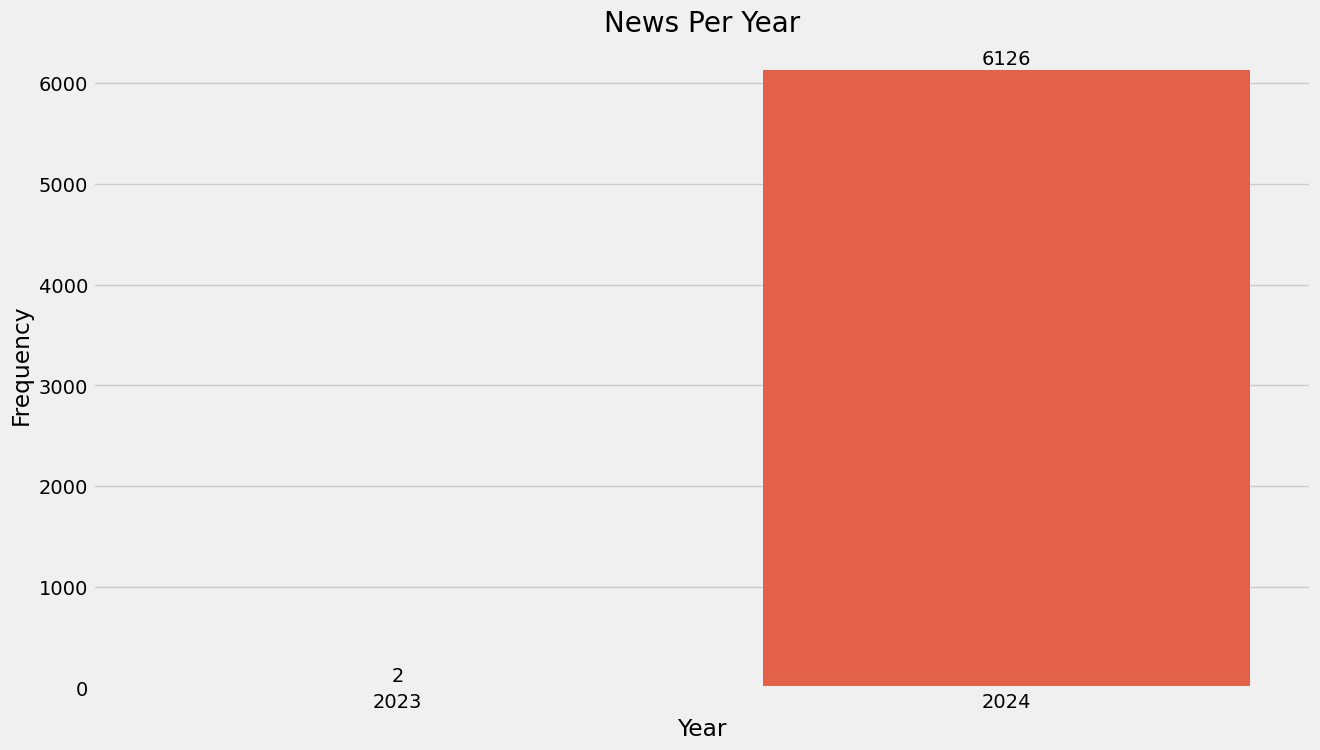

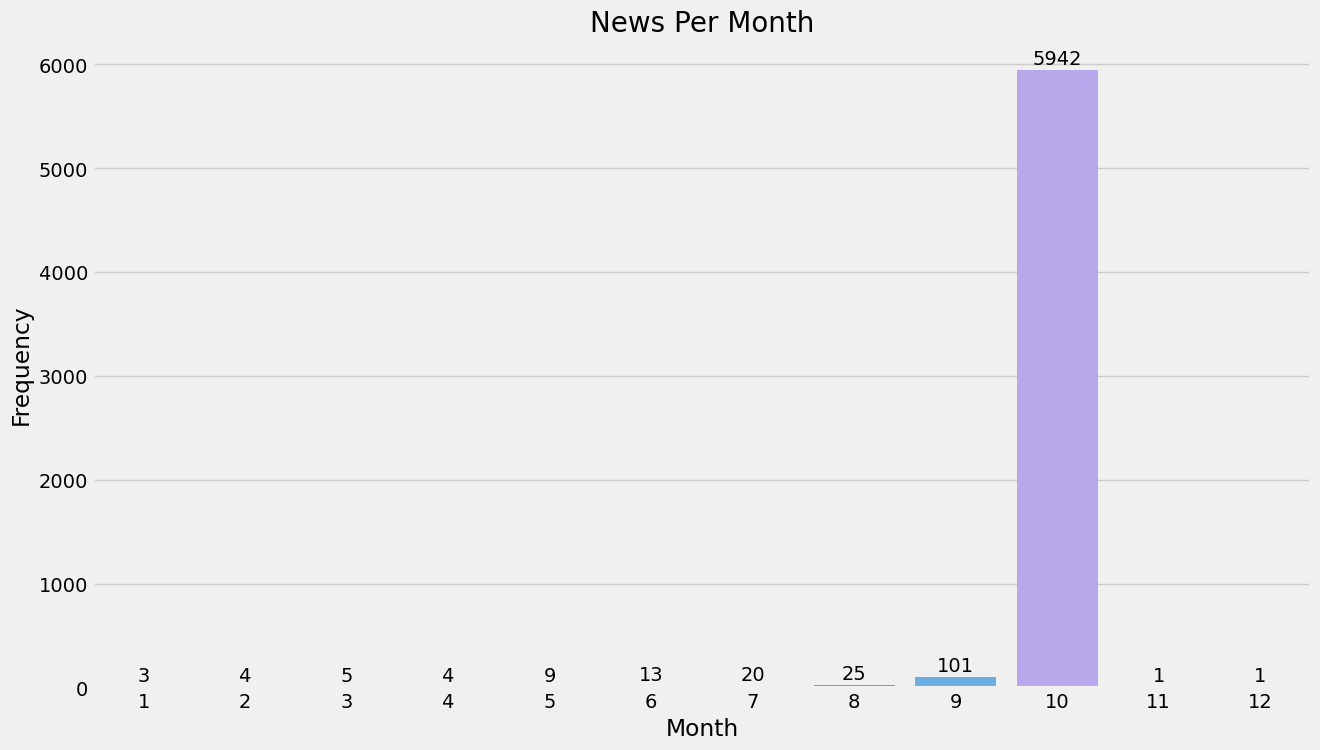

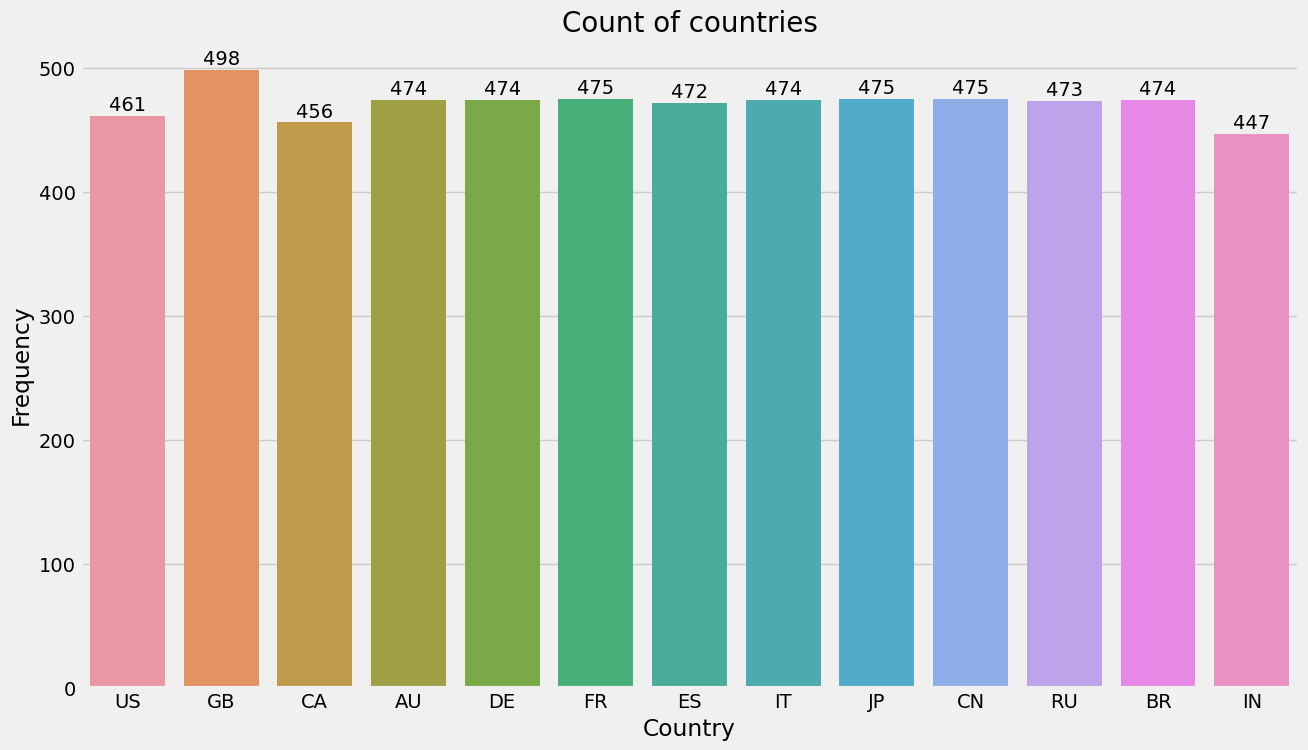

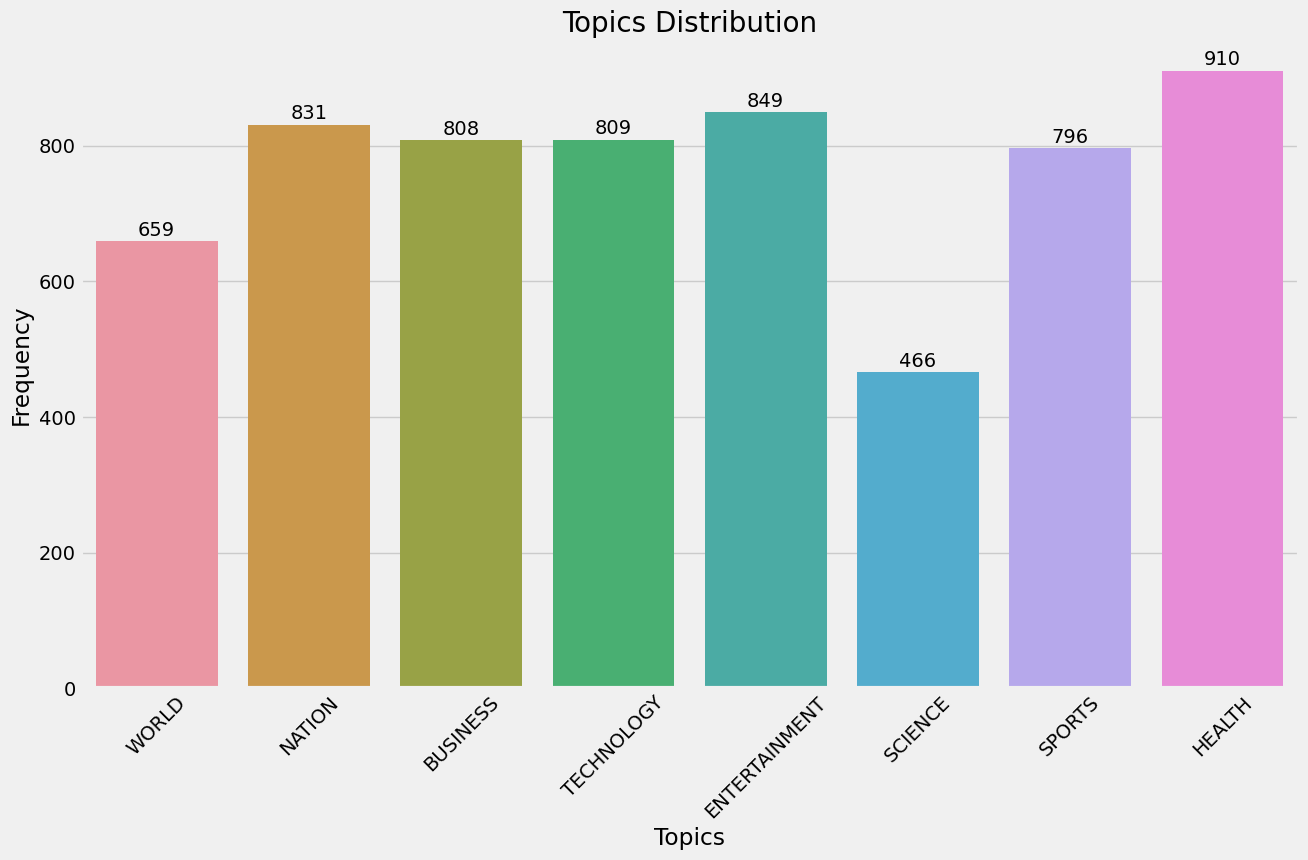

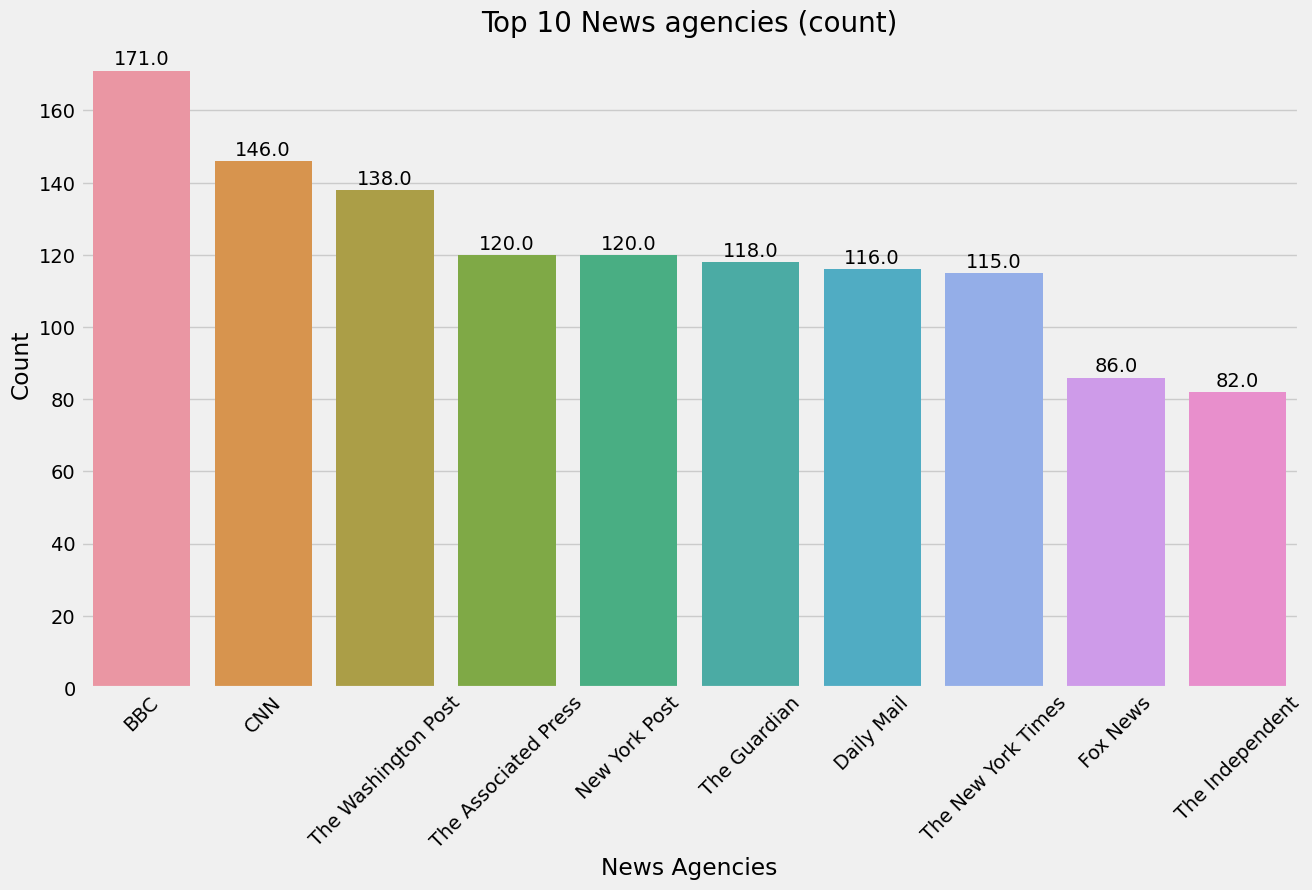

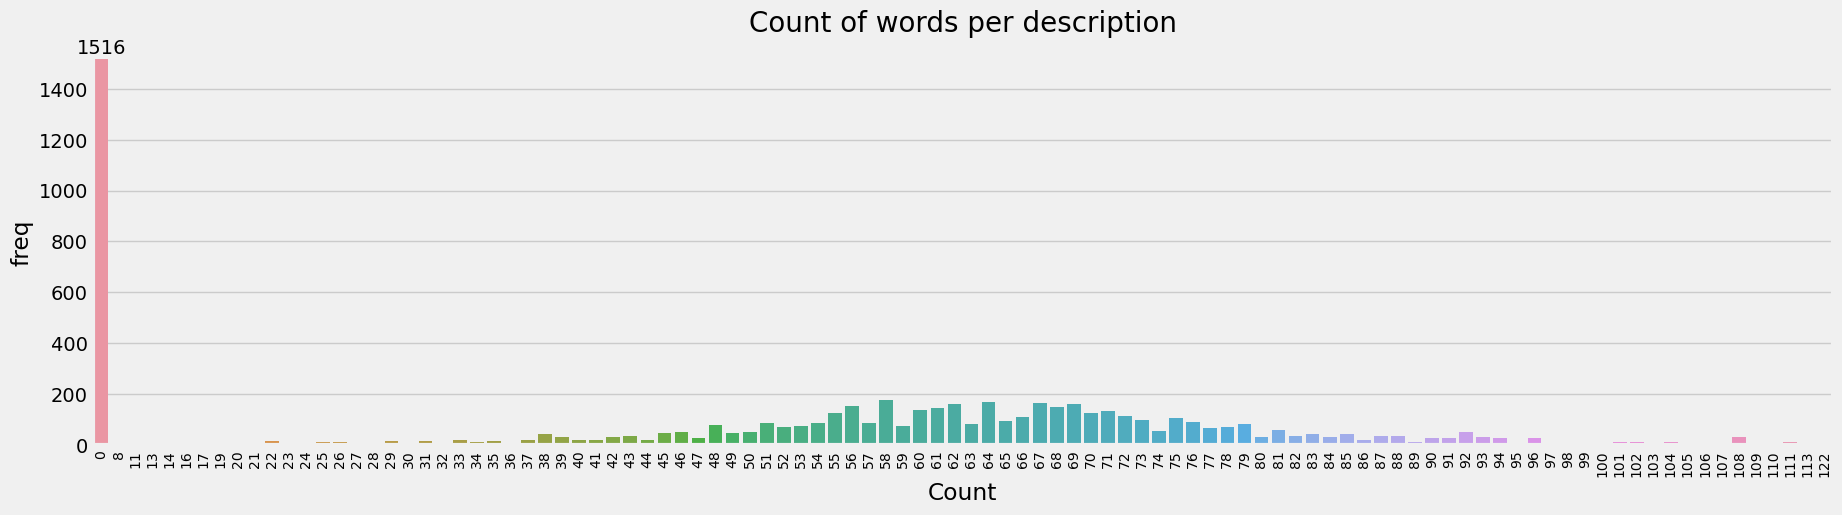

In [90]:
google.visua_report(df)

In [91]:
df.query('word_count == 0')

title      News_agency  \
37    Father called UK police to confess to killing ...         Fox News   
42    Israel will ‘hit Hezbollah mercilessly in all ...  All Israel News   
68    Supreme Court tosses lower court decision that...         CBS News   
78    Supreme Court leaves in place Pennsylvania law...              CNN   
111   UnitedHealth forecasts 2025 profit below Stree...    Yahoo Finance   
...                                                 ...              ...   
6118         Foods to Eat During Your Period - PTC News         PTC News   
6119  Diet guide: Here's how much nutrition you need...     Moneycontrol   
6120  Fed up of zits and pimples? 9 acne-friendly fo...        Firstpost   
6121  No updated seasonal diseases data from Telanga...        The Hindu   
6122  The Protein Rules Athletes Should Follow (or I...          Outside   

                                                    URL summary Country  \
37    https://news.google.com/rss/articles/CBMisgFBV...     NaN      US   
42    https://news.google.com/rss/articles/CBMivwFBV...     NaN      US   
68    https://news.google.com/rss/articles/CBMikAFBV...     NaN      US   
78    https://news.google.com/rss/articles/CBMilgFBV...     NaN      US   
111   https://news.google.com/rss/articles/CBMilgFBV...     NaN      US   
...                                                 ...     ...     ...   
6118  https://news.google.com/rss/articles/CBMiqgFBV...     NaN      IN   
6119  https://news.google.com/rss/articles/CBMi0gFBV...     NaN      IN   
6120  https://news.google.com/rss/articles/CBMi1AFBV...     NaN      IN   
6121  https://news.google.com/rss/articles/CBMi3wFBV...     NaN      IN   
6122  https://news.google.com/rss/articles/CBMid0FVX...     NaN      IN   

     language       tag             published_date  published_year  \
37         en     WORLD  2024-10-15 05:18:00+00:00            2024   
42         en     WORLD  2024-10-14 18:33:45+00:00            2024   
68         en    NATION  2024-10-15 14:28:19+00:00            2024   
78         en    NATION  2024-10-15 13:46:00+00:00            2024   
111        en  BUSINESS  2024-10-15 14:30:46+00:00            2024   
...       ...       ...                        ...             ...   
6118       en    HEALTH  2024-10-14 09:48:28+00:00            2024   
6119       en    HEALTH  2024-10-14 06:20:28+00:00            2024   
6120       en    HEALTH  2024-10-14 09:21:18+00:00            2024   
6121       en    HEALTH  2024-10-14 06:11:00+00:00            2024   
6122       en    HEALTH  2024-10-15 06:00:00+00:00            2024   

      published_month  published_day  word_count  sent_count  stopwords_count  \
37                 10             15           0           0                0   
42                 10             14           0           0                0   
68                 10             15           0           0                0   
78                 10             15           0           0                0   
111                10             15           0           0                0   
...               ...            ...         ...         ...              ...   
6118               10             14           0           0                0   
6119               10             14           0           0                0   
6120               10             14           0           0                0   
6121               10             14           0           0                0   
6122               10             15           0           0                0   

                                              merged_TS  \
37    Father called UK police to confess to killing ...   
42    Israel will ‘hit Hezbollah mercilessly in all ...   
68    Supreme Court tosses lower court decision that...   
78    Supreme Court leaves in place Pennsylvania law...   
111   UnitedHealth forecasts 2025 profit below Stree...   
...                                                 ...   
6118     

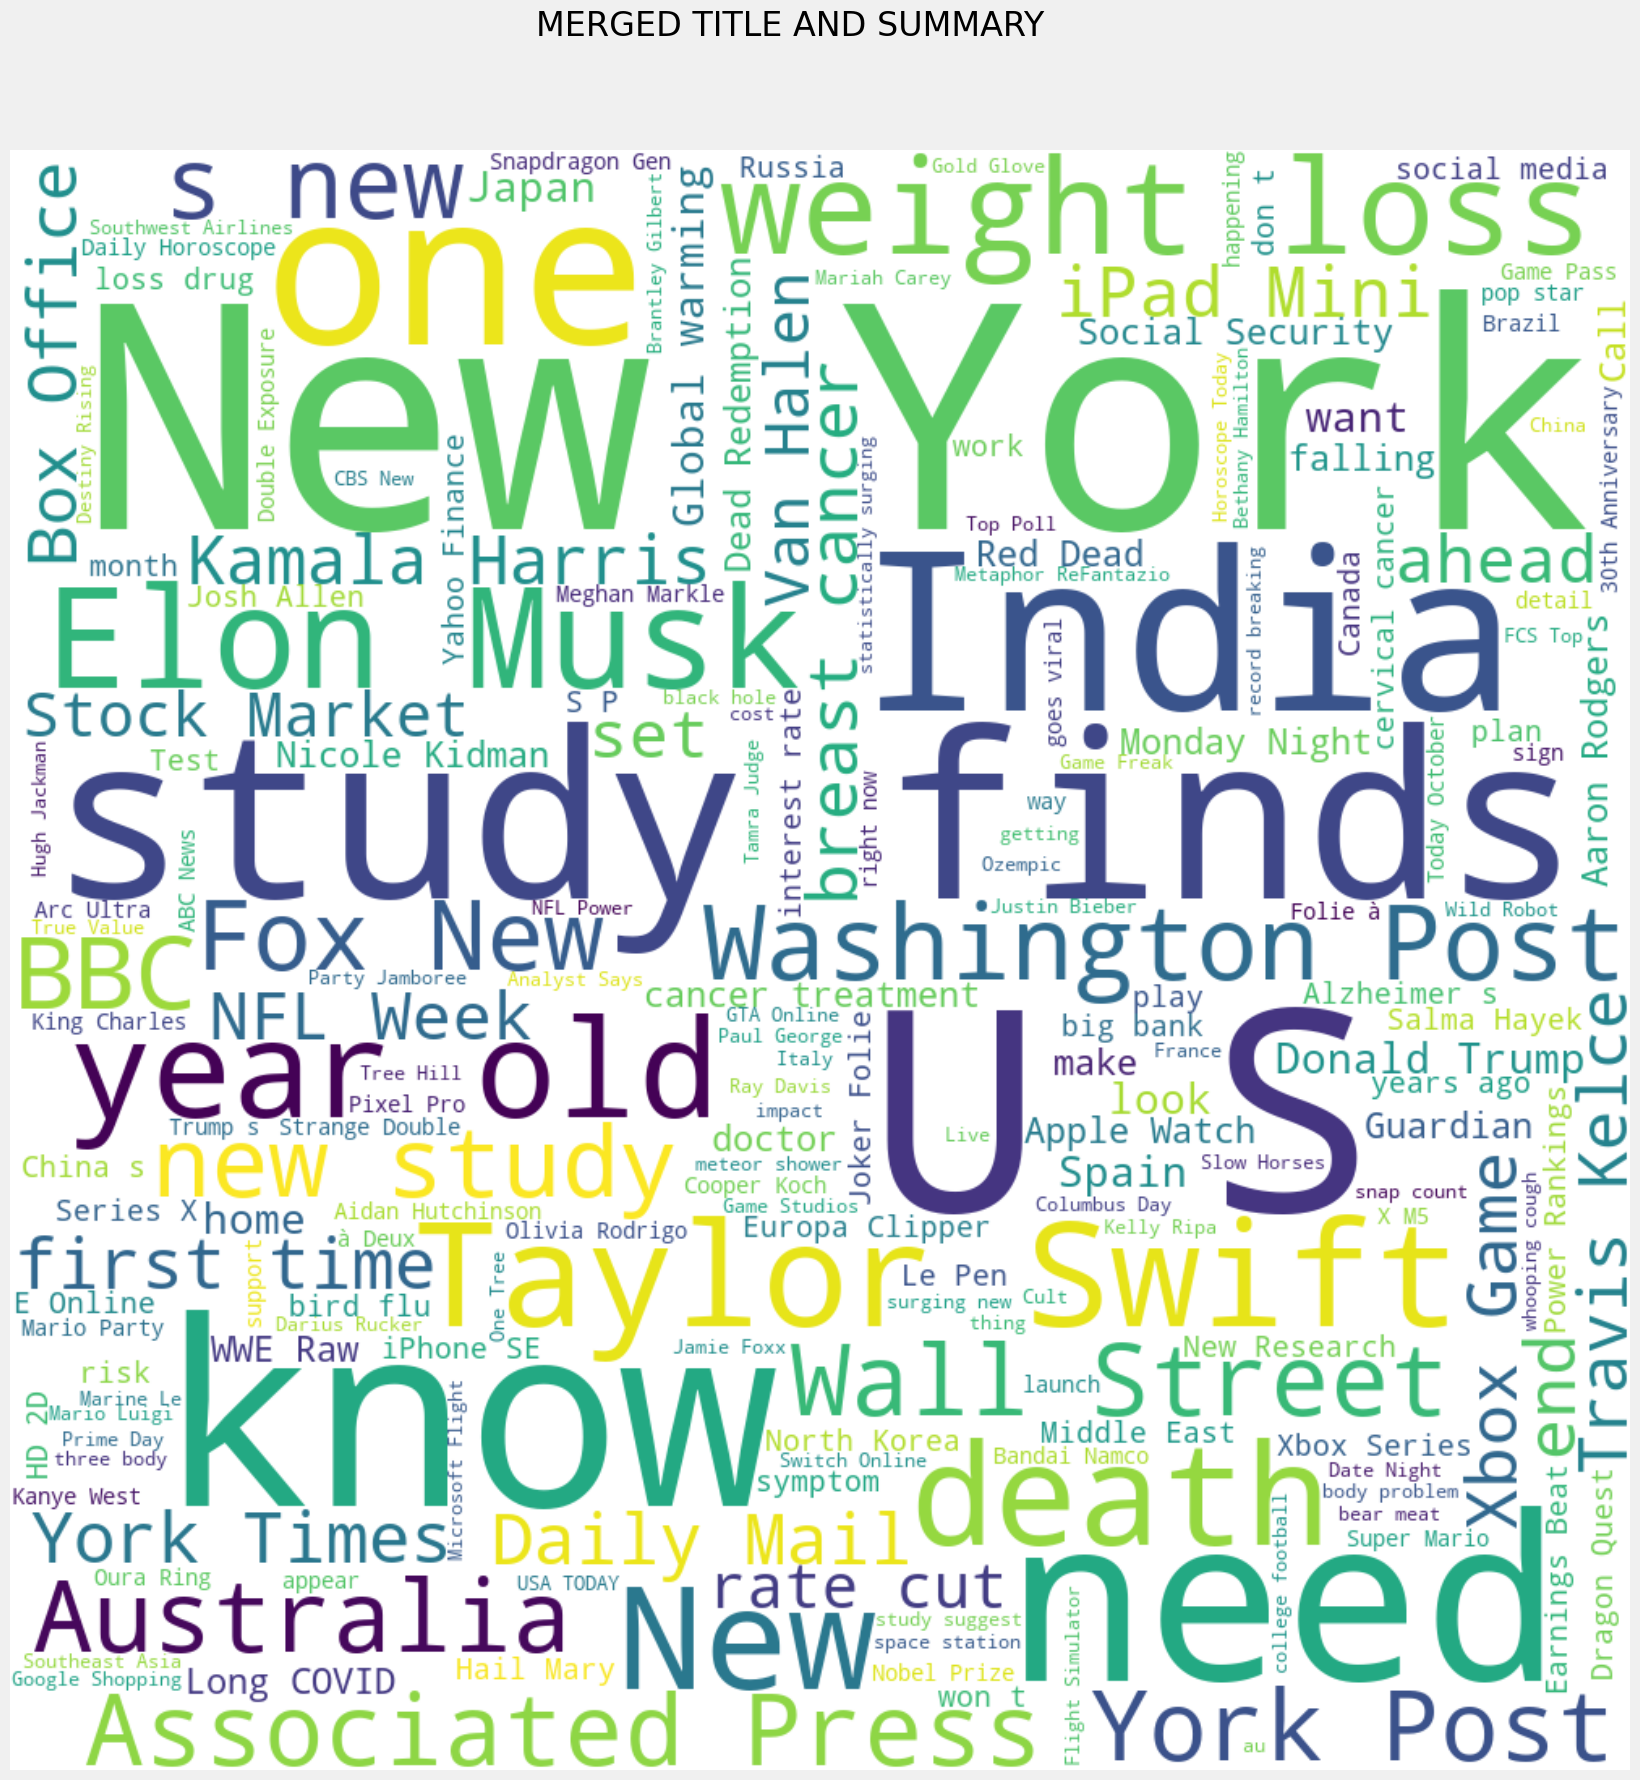

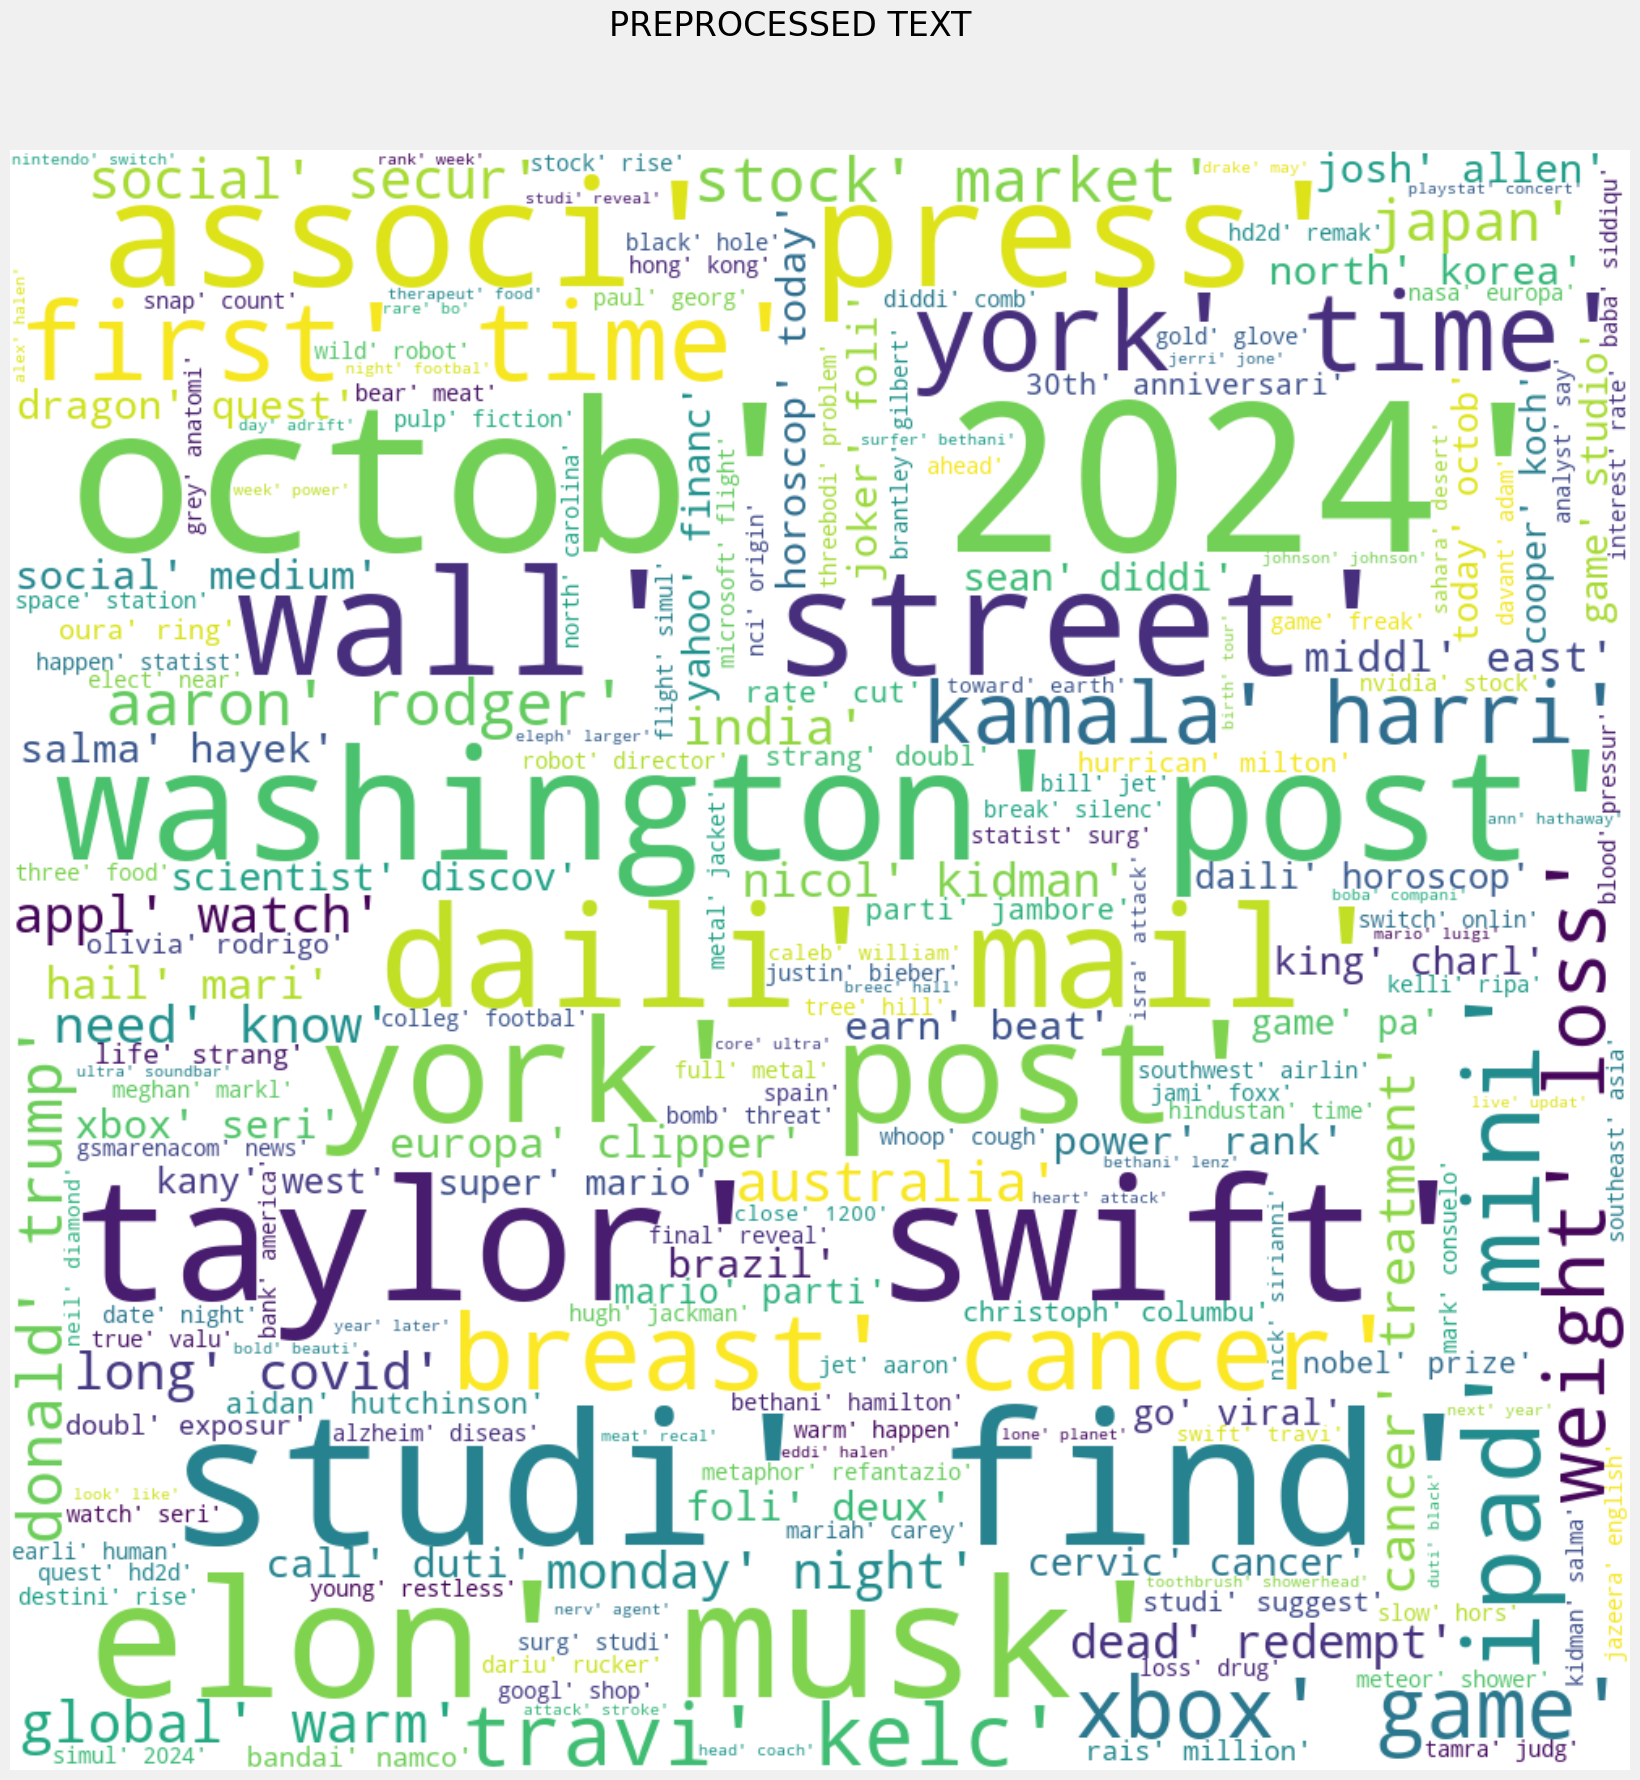

In [92]:
google.create_wordclouds(df)

# TOPIC MODELING 

In [93]:
import gensim
from gensim import corpora
from gensim.models import LdaModel
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

In [94]:
example_preprocessed = df.preprocessed_text.values[0]
example_preprocessed

"['canada', 'india', 'expel', 'diplomat', 'kill', 'sikh', 'activist', 'financi', 'time', 'canada', 'india', 'expel', 'diplomat', 'kill', 'sikh', 'activist', 'trudeau', 'move', 'cast', 'light', 'reach', 'india', 'intellig', 'agenc', 'canadaindia', 'diplomat', 'sikh', 'activist', 'assassin', 'grow', 'diplomat', 'expel', 'canadian', 'polic', 'accus', 'india', 'work', 'crimin', 'network', 'kill', 'dissid']"

In [95]:
# Tokenize the preprocessed text
df['tokenized_text'] = df['preprocessed_text'].apply(lambda x: x.split())

# Creating a dictionary out of the tokenized text
dictionary = corpora.Dictionary(df['tokenized_text'])

# applying filters...
dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=1000)

# Bag of Words corpus..
corpus = [dictionary.doc2bow(text) for text in df['tokenized_text']]

# Apply LDA model
model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=10, random_state=100,
                     update_every=1, chunksize=100, passes=10, alpha='auto', per_word_topics=True)


In [96]:
# looking at the top 10 topics from the model..
for idx, topic in model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.083*"'stock'," + 0.073*"'share'," + 0.044*"'fall'," + 0.033*"'earn'," + 0.032*"'today'," + 0.029*"'know'," + 0.027*"'improv'," + 0.026*"'symptom'," + 0.021*"'england'," + 0.020*"'warn',"
Topic: 1 
Words: 0.059*"'studi'," + 0.056*"'reveal'," + 0.053*"'test'," + 0.030*"'nasa'," + 0.029*"'space'," + 0.025*"'reduc'," + 0.020*"'still'," + 0.019*"'asteroid'," + 0.018*"'offer'," + 0.017*"'earth',"
Topic: 2 
Words: 0.057*"'health'," + 0.042*"'case'," + 0.040*"'star'," + 0.037*"'israel'," + 0.027*"'say'," + 0.027*"'report'," + 0.024*"'play'," + 0.020*"'outbreak'," + 0.019*"'target'," + 0.019*"'amid',"
Topic: 3 
Words: 0.033*"'food'," + 0.030*"'risk'," + 0.029*"'take'," + 0.026*"'diabet'," + 0.025*"'chang'," + 0.024*"'time'," + 0.021*"'diet'," + 0.020*"'young'," + 0.020*"'heart'," + 0.017*"'rais',"
Topic: 4 
Words: 0.052*"'cancer'," + 0.033*"'watch'," + 0.031*"'appl'," + 0.025*"'video'," + 0.024*"'best'," + 0.023*"'player'," + 0.022*"'seri'," + 0.021*"'bank'," + 0.020*"'woman'

In [97]:
# # Create interactive visualization
# interactive_visual =  gensimvis.prepare(model, corpus, dictionary, n_jobs=1)
# pyLDAvis.save_html(interactive_visual, 'LDA_Interactive_visual.html')